Importar Librerias a usar

In [5]:
import pandas as pd
import numpy as np
import ast
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Análisis Exploratorio de ENIGH y ENCO
Este notebook realiza un análisis exploratorio de los datos de la Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) y Encuesta Nacional sobre Confianza del Consumidor (ENCO).
El objetivo principal es entender las dinámicas económicas de los estados en México, analizar la desigualdad a través del coeficiente GINI y explorar percepciones optimistas, pesimistas y mixtas.


## Análisis del ENIGH (Encuesta Nacional de Ingresos y Gastos de los Hogares)
Esta sección carga y procesa los datos del ENIGH, que ofrece información sobre los ingresos, gastos y condiciones socioeconómicas de los hogares en México.

### Objetivo:
- Analizar cómo la desigualdad económica, medida por el coeficiente GINI, se distribuye entre los municipios.
- Relacionar los ingresos por deciles socioeconómicos con las percepciones de optimismo, pesimismo y respuestas mixtas.

### Actividades:
1. Importación y limpieza de los datos de ENIGH.
2. Mapeo de códigos de estados a nombres completos para una mejor interpretación geográfica.
3. Cálculo y normalización de métricas relacionadas con desigualdad e ingresos.


In [ ]:
df_enigh = pd.read_csv("data\processed\enigh\enigh_processed_tidy.csv")

En esta celda se carga el conjunto de datos procesado de la ENIGH desde un archivo CSV y se crea un DataFrame llamado `df_enigh`. Luego, se define un diccionario que mapea los códigos de los estados mexicanos a sus nombres. Este mapeo se aplica a la columna `entidad` del DataFrame, creando una nueva columna `estado_nombre` que facilita la interpretación de los datos y su análisis geográfico a nivel estatal.


In [7]:
# Define the mapping of state codes to state names
estados = {
    1: 'AGUASCALIENTES', 2: 'BAJA CALIFORNIA', 3: 'BAJA CALIFORNIA SUR', 4: 'CAMPECHE',
    5: 'COAHUILA DE ZARAGOZA', 6: 'COLIMA', 7: 'CHIAPAS', 8: 'CHIHUAHUA', 9: 'DISTRITO FEDERAL',
    10: 'DURANGO', 11: 'GUANAJUATO', 12: 'GUERRERO', 13: 'HIDALGO', 14: 'JALISCO', 15: 'MEXICO',
    16: 'MICHOACAN DE OCAMPO', 17: 'MORELOS', 18: 'NAYARIT', 19: 'NUEVO LEON', 20: 'OAXACA',
    21: 'PUEBLA', 22: 'QUERETARO DE ARTEAGA', 23: 'QUINTANA ROO', 24: 'SAN LUIS POTOSI', 25: 'SINALOA',
    26: 'SONORA', 27: 'TABASCO', 28: 'TAMAULIPAS', 29: 'TLAXCALA', 30: 'VERACRUZ DE IGNACIO DE LA LLAVE',
    31: 'YUCATAN', 32: 'ZACATECAS', 33: 'ENTIDAD FEDERATIVA NO ESPECIFICADA'
}

# Map 'entidad' in the data to state names
df_enigh['estado_nombre'] = df_enigh['entidad'].map(estados)

In [8]:
def calcular_gini_y_deciles(df, year):
    # Filtrar datos para el año especificado
    grupo = df[df['year'] == year].copy()

    # Calcular el total de hogares
    total_hogares = grupo['factor'].sum()
    if total_hogares == 0:
        return None  # Retornar None si no hay hogares

    # Ordenar el grupo por ingreso y calcular el tamaño del decil
    grupo = grupo.sort_values(by='ing_cor').reset_index(drop=True)
    tam_dec = int(total_hogares // 10)

    # Sumar acumulativamente el factor para dividir en deciles
    grupo['ACUMULA'] = grupo['factor'].cumsum()
    grupo['DECIL'] = pd.cut(grupo['ACUMULA'], bins=[0] + [tam_dec * i for i in range(1, 11)], labels=range(1, 11), include_lowest=True)

    # Calcular el ingreso promedio y el número de hogares por decil, solo si el factor > 0
    ingresos_por_decil = grupo.groupby('DECIL', observed=True).apply(
        lambda x: np.average(x['ing_cor'], weights=x['factor']) if x['factor'].sum() > 0 else 0, include_groups=False
    )
    hogares_por_decil = grupo.groupby('DECIL', observed=True)['factor'].sum()

    # Crear tabla de deciles similar a la usada en INEGI
    tabla_deciles = pd.DataFrame({
        'hogares': hogares_por_decil,
        'ingreso_promedio': ingresos_por_decil
    }).reset_index()

    # Calcular el Gini usando ingresos promedio por decil ponderados por el número de hogares
    ingresos = tabla_deciles['ingreso_promedio'].values
    hogares = tabla_deciles['hogares'].values
    ingresos_totales = ingresos.dot(hogares)
    hogares_totales = hogares.sum()

    # Calcular la fracción acumulada de ingresos y hogares para el Gini
    ingresos_acumulados = np.cumsum(ingresos * hogares) / ingresos_totales
    hogares_acumulados = np.cumsum(hogares) / hogares_totales

    # Calcular el área entre la curva de Lorenz y la línea de igualdad perfecta (Gini)
    gini = 1 - np.sum((hogares_acumulados[1:] - hogares_acumulados[:-1]) * (ingresos_acumulados[1:] + ingresos_acumulados[:-1]))

    # Retornar los resultados
    return {
        'year': year,
        'gini': gini,
        'ingresos_por_decil': ingresos_por_decil.to_dict()
    }

# Calcular Gini y deciles por año
resultados = []
for year in [2018, 2020, 2022]:
    resultado = calcular_gini_y_deciles(df_enigh, year)
    if resultado:
        resultados.append(resultado)

# Convertir los resultados a un DataFrame para visualizar
df_resultados_nacional = pd.DataFrame(resultados)


En esta celda se define la función `calcular_gini_y_deciles` que calcula el índice de Gini y los ingresos promedio por decil para un año específico. La función sigue estos pasos:

1. **Filtrar los datos por año**: Se selecciona el subconjunto de datos correspondientes al año de interés.
2. **Calcular el total de hogares**: Se calcula la suma del factor de ponderación para obtener el total de hogares en el año seleccionado.
3. **Ordenar los datos por ingreso**: Se ordenan los hogares por ingreso y se dividen en 10 grupos (deciles) según la acumulación del factor.
4. **Calcular el ingreso promedio por decil**: Para cada decil, se calcula el ingreso promedio ponderado por el factor de cada hogar.
5. **Calcular el índice de Gini**: Se calcula el índice de Gini utilizando los ingresos promedio y los hogares por decil, basándose en el área bajo la curva de Lorenz.

La función se ejecuta para los años 2018, 2020 y 2022, y los resultados (índice de Gini y los ingresos por decil) se almacenan en un DataFrame `df_resultados_nacional` para su posterior análisis.

Este proceso permite evaluar la desigualdad económica en México para estos años utilizando el índice de Gini, lo que es clave para entender las disparidades de ingreso a nivel nacional.


In [9]:
# Mostrar los resultados
df_resultados_nacional

,year,gini,ingresos_por_decil
0,2018,0.427890,"{1: 9151.96375439752, 2: 16166.25424018117, 3:..."
1,2020,0.416387,"{1: 9937.559700470325, 2: 16862.254149039334, ..."
2,2022,0.404009,"{1: 13409.50266340002, 2: 22420.454266375575, ..."


In [10]:
# Ordenar el DataFrame por año para asegurar secuencia correcta
df_cambios_nacionales = df_resultados_nacional.sort_values(by='year').reset_index(drop=True)
# Calcular el ingreso promedio a partir de la columna 'ingresos_por_decil'
df_cambios_nacionales['promedio_ingresos'] = df_cambios_nacionales['ingresos_por_decil'].apply(lambda x: np.mean(list(x.values())))

# Calcular las diferencias absolutas y porcentuales de 'avg_income' y 'gini'
df_cambios_nacionales['diff_income_abs'] = df_cambios_nacionales['promedio_ingresos'].diff()
df_cambios_nacionales['diff_income_pct'] = df_cambios_nacionales['promedio_ingresos'].pct_change() * 100  # Cambios en porcentaje

df_cambios_nacionales['diff_gini_abs'] = df_cambios_nacionales['gini'].diff()
df_cambios_nacionales['diff_gini_pct'] = df_cambios_nacionales['gini'].pct_change() * 100  # Cambios en porcentaje

# Mostrar el DataFrame resultante
df_cambios_nacionales[['year', 'promedio_ingresos', 'diff_income_abs', 'diff_income_pct', 'gini', 'diff_gini_abs', 'diff_gini_pct']]

,year,promedio_ingresos,diff_income_abs,diff_income_pct,gini,diff_gini_abs,diff_gini_pct
0,2018,49840.968661,NaN,NaN,0.427890,NaN,NaN
1,2020,50268.637763,427.669102,0.858067,0.416387,-0.011503,-2.688394
2,2022,63686.529660,13417.891897,26.692372,0.404009,-0.012378,-2.972731


En esta celda se realiza un análisis adicional de los resultados obtenidos en la celda anterior. Primero, se ordena el DataFrame `df_resultados_nacional` por año para asegurar que los datos se presenten en secuencia cronológica.

A continuación, se calcula el ingreso promedio por decil a partir de la columna `ingresos_por_decil` utilizando la función `apply` para obtener la media de los ingresos de cada decil.

Se calculan las **diferencias absolutas y porcentuales** tanto para el ingreso promedio como para el índice de Gini entre los años. Esto permite observar la evolución de la desigualdad económica y el ingreso promedio de los hogares en México entre los años 2018, 2020 y 2022.

Finalmente, el DataFrame resultante muestra las siguientes columnas: año, ingreso promedio, diferencias absolutas y porcentuales del ingreso y del Gini, proporcionando una visión clara de los cambios en la desigualdad económica a lo largo de estos años.


In [11]:
# Expandir la columna de 'ingresos_por_decil' en columnas separadas para cada decil
decil_nacional_df = df_resultados_nacional['ingresos_por_decil'].apply(pd.Series)
decil_nacional_df.columns = [f'decil_{i}' for i in range(1, 11)]

# Concatenar el DataFrame original con las nuevas columnas de deciles
df_cambios_decil_nacional = pd.concat([df_resultados_nacional, decil_nacional_df], axis=1)

# Ordenar el DataFrame por 'estado' y 'year' para garantizar un cálculo correcto
df_cambios_decil_nacional = df_cambios_decil_nacional.sort_values(by=[ 'year']).reset_index(drop=True)

# Calcular el crecimiento porcentual de ingresos por decil entre años a nivel nacional
for i in range(1, 11):
    df_cambios_decil_nacional[f'decil_{i}_growth_pct'] = df_cambios_decil_nacional[f'decil_{i}'].pct_change() * 100

#  Guardar en un nuevo DataFrame resultante
df_resultados_deciles_cambios_nacional = df_cambios_decil_nacional[['year'] + [f'decil_{i}_growth_pct' for i in range(1, 11)]]
# Ver resultados
df_resultados_deciles_cambios_nacional

,year,decil_1_growth_pct,decil_2_growth_pct,decil_3_growth_pct,decil_4_growth_pct,decil_5_growth_pct,decil_6_growth_pct,decil_7_growth_pct,decil_8_growth_pct,decil_9_growth_pct,decil_10_growth_pct
0,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,8.583906,4.305264,3.537468,2.844910,2.855871,2.580302,2.573238,2.502868,1.920556,-2.908725
2,2022,34.937581,32.962379,31.097995,30.437832,29.894016,29.464139,28.235618,26.631469,25.396281,23.167332


En esta celda se realiza una expansión de la columna `ingresos_por_decil`, que contiene los ingresos promedio por cada uno de los 10 deciles, separándola en columnas individuales para cada decil. Cada nueva columna recibe el nombre `decil_1`, `decil_2`, ..., hasta `decil_10`, lo que facilita el análisis de los ingresos específicos de cada decil a lo largo del tiempo.

A continuación, se concatenan estas nuevas columnas al DataFrame original `df_resultados_nacional`, y se ordenan por año para asegurar que los cálculos sean correctos a nivel temporal.

Luego, se calcula el **crecimiento porcentual de los ingresos** por decil entre los años disponibles (2018, 2020 y 2022). Este cálculo permite observar cómo varía el ingreso de cada decil entre los años, proporcionando información sobre cómo los diferentes grupos de ingreso han experimentado cambios económicos.

Finalmente, se guarda el DataFrame `df_resultados_deciles_cambios_nacional`, que contiene el crecimiento porcentual de los ingresos por cada decil a nivel nacional, y se muestra para su análisis.


In [12]:
# Crear columnas de entidad y municipio a partir de la columna ubica_geo, si no están presentes
if 'entidad' not in df_enigh.columns or 'municipio' not in df_enigh.columns:
    df_enigh['entidad'] = df_enigh['ubica_geo'].astype(str).str[:-3].astype(int)
    df_enigh['municipio'] = df_enigh['ubica_geo'].astype(str).str[-3:].astype(int)


In [13]:
def calcular_gini_y_deciles_por_estado(df):
    # Lista para almacenar los resultados por estado y año
    resultados = []

    # Agrupamos por 'year' y 'entidad' (estado)
    for (year, entidad), grupo in df.groupby(['year', 'entidad']):

        # Calcular el total de hogares en el grupo
        total_hogares = grupo['factor'].sum()
        if total_hogares == 0:
            continue  # Omitir el grupo si no hay hogares

        # Ordenar el grupo por ingreso y calcular el tamaño del decil
        grupo = grupo.sort_values(by='ing_cor').reset_index(drop=True)
        tam_dec = int(total_hogares // 10)  # Tamaño del decil truncado

        # Sumar acumulativamente el factor para dividir en deciles
        grupo['ACUMULA'] = grupo['factor'].cumsum()
        grupo['DECIL'] = pd.cut(grupo['ACUMULA'], bins=[0] + [tam_dec * i for i in range(1, 11)], labels=range(1, 11), include_lowest=True)

        # Calcular el ingreso promedio y el número de hogares por decil, solo si el factor > 0
        ingresos_por_decil = grupo.groupby('DECIL', observed=True).apply(
            lambda x: np.average(x['ing_cor'], weights=x['factor']) if x['factor'].sum() > 0 else 0, include_groups=False
        )
        hogares_por_decil = grupo.groupby('DECIL', observed=True)['factor'].sum()

        # Crear tabla de deciles para calcular el Gini
        tabla_deciles = pd.DataFrame({
            'hogares': hogares_por_decil,
            'ingreso_promedio': ingresos_por_decil
        }).reset_index()

        # Calcular el Gini usando ingresos promedio por decil ponderados por el número de hogares
        ingresos = tabla_deciles['ingreso_promedio'].values
        hogares = tabla_deciles['hogares'].values
        ingresos_totales = ingresos.dot(hogares)
        hogares_totales = hogares.sum()

        # Calcular la fracción acumulada de ingresos y hogares para el Gini
        ingresos_acumulados = np.cumsum(ingresos * hogares) / ingresos_totales
        hogares_acumulados = np.cumsum(hogares) / hogares_totales

        # Calcular el área entre la curva de Lorenz y la línea de igualdad perfecta (Gini)
        gini = 1 - np.sum((hogares_acumulados[1:] - hogares_acumulados[:-1]) * (ingresos_acumulados[1:] + ingresos_acumulados[:-1]))

        # Almacenar los resultados para este estado y año
        resultados.append({
            'year': year,
            'estado': grupo['estado_nombre'].iloc[0],
            'entidad': entidad,
            'gini': gini,
            'ingresos_por_decil': ingresos_por_decil.to_dict()
        })

    # Convertir los resultados a un DataFrame para facilitar la visualización
    df_resultados = pd.DataFrame(resultados)
    return df_resultados



In [14]:
# Calcular Gini y deciles por estado y año
df_resultados_por_estado = calcular_gini_y_deciles_por_estado(df_enigh)

# Mostrar los resultados
df_resultados_por_estado

,year,estado,entidad,gini,ingresos_por_decil
0,2018,AGUASCALIENTES,1,0.391868,"{1: 12897.004214827297, 2: 21632.406708729133,..."
1,2018,BAJA CALIFORNIA,2,0.380719,"{1: 14237.357488951204, 2: 22686.515374712646,..."
2,2018,BAJA CALIFORNIA SUR,3,0.377081,"{1: 15551.894506027196, 2: 25963.08206786035, ..."
3,2018,CAMPECHE,4,0.429700,"{1: 8667.04770159055, 2: 14702.759441418617, 3..."
4,2018,COAHUILA DE ZARAGOZA,5,0.391121,"{1: 12288.187593156617, 2: 20583.067962363028,..."
...,...,...,...,...,...
91,2022,TAMAULIPAS,28,0.374787,"{1: 14323.353483869223, 2: 24180.353357730688,..."
92,2022,TLAXCALA,29,0.336912,"{1: 13666.800018524662, 2: 20532.90198398626, ..."
93,2022,VERACRUZ DE IGNACIO DE LA LLAVE,30,0.393564,"{1: 10013.872418311354, 2: 16677.85942718583, ..."
94,2022,YUCATAN,31,0.390186,"{1: 14271.221113875514, 2: 22764.37680595659, ..."


En esta celda, se crean dos nuevas columnas en el DataFrame `df_enigh` a partir de la columna `ubica_geo` si no están presentes. Estas columnas corresponden a los identificadores de **entidad (estado)** y **municipio**, los cuales son extraídos de los primeros tres y últimos tres dígitos de `ubica_geo`, respectivamente.

A continuación, se define la función `calcular_gini_y_deciles_por_estado`, que calcula el índice de Gini y los ingresos promedio por decil para cada estado y año. El proceso es el siguiente:

1. **Agrupar por año y estado**: Se agrupan los datos por año y entidad (estado) para calcular los deciles y el índice de Gini a nivel estatal.
2. **Calcular los deciles**: Similar a la función anterior, se ordenan los hogares por ingreso y se dividen en 10 grupos (deciles). Para cada decil, se calcula el ingreso promedio ponderado por el factor de ponderación.
3. **Calcular el Gini**: Se calcula el índice de Gini utilizando los ingresos promedio de cada decil y los hogares en cada grupo.
4. **Almacenar los resultados**: Se almacenan los resultados por estado y año en un DataFrame que incluye el índice de Gini y los ingresos por decil.

Finalmente, la función retorna un DataFrame `df_resultados` con los resultados del cálculo para cada estado y año, lo que permite evaluar la desigualdad económica a nivel estatal.


In [15]:
# Ordenar el DataFrame por 'estado' y 'year' para asegurar un cálculo secuencial
df_cambios_por_estado = df_resultados_por_estado.sort_values(by=['estado', 'year']).reset_index(drop=True)
# Calcular el ingreso promedio a partir de la columna 'ingresos_por_decil'
df_cambios_por_estado['promedio_ingresos'] = df_cambios_por_estado['ingresos_por_decil'].apply(lambda x: np.mean(list(x.values())))

# Calcular diferencias de ingresos promedio y Gini por estado entre años
df_cambios_por_estado['diff_income_abs'] = df_cambios_por_estado.groupby('estado')['promedio_ingresos'].diff()
df_cambios_por_estado['diff_income_pct'] = df_cambios_por_estado.groupby('estado')['promedio_ingresos'].pct_change() * 100

df_cambios_por_estado['diff_gini_abs'] = df_cambios_por_estado.groupby('estado')['gini'].diff()
df_cambios_por_estado['diff_gini_pct'] = df_cambios_por_estado.groupby('estado')['gini'].pct_change() * 100

# Mostrar el DataFrame con los resultados
df_cambios_por_estado[['year', 'estado', 'promedio_ingresos', 'diff_income_abs', 'diff_income_pct', 'gini', 'diff_gini_abs', 'diff_gini_pct']]


,year,estado,promedio_ingresos,diff_income_abs,diff_income_pct,gini,diff_gini_abs,diff_gini_pct
0,2018,AGUASCALIENTES,58691.265596,NaN,NaN,0.391868,NaN,NaN
1,2020,AGUASCALIENTES,58205.951157,-485.314439,-0.826894,0.377191,-0.014677,-3.745331
2,2022,AGUASCALIENTES,77725.786454,19519.835297,33.535807,0.401896,0.024704,6.549573
3,2018,BAJA CALIFORNIA,59141.454197,NaN,NaN,0.380719,NaN,NaN
4,2020,BAJA CALIFORNIA,66064.790280,6923.336083,11.706402,0.386445,0.005726,1.503905
...,...,...,...,...,...,...,...,...
91,2020,YUCATAN,46034.006397,-2797.816804,-5.729495,0.431070,0.013741,3.292496
92,2022,YUCATAN,61436.222910,15402.216513,33.458345,0.390186,-0.040884,-9.484318
93,2018,ZACATECAS,37938.907514,NaN,NaN,0.399324,NaN,NaN
94,2020,ZACATECAS,43034.172975,5095.265461,13.430185,0.410048,0.010723,2.685376


En esta celda, se realiza un análisis más detallado de los resultados obtenidos por estado. Primero, se ordena el DataFrame `df_resultados_por_estado` por las columnas `estado` y `year` para garantizar que los cálculos sean correctos y secuenciales por estado y año.

A continuación, se calcula el **ingreso promedio** por estado a partir de la columna `ingresos_por_decil`, usando la función `apply` para obtener la media de los ingresos de cada decil.

Luego, se calculan las **diferencias absolutas y porcentuales** tanto para el ingreso promedio como para el índice de Gini a nivel estatal entre los años disponibles. Esto permite observar cómo ha evolucionado la desigualdad económica y el ingreso promedio de los hogares en cada estado a lo largo del tiempo.

Finalmente, se muestra el DataFrame `df_cambios_por_estado` con las siguientes columnas: año, estado, ingreso promedio, diferencias absolutas y porcentuales de los ingresos y el Gini, proporcionando una visión detallada de los cambios en la desigualdad económica y los ingresos a nivel estatal entre los años 2018, 2020 y 2022.


In [16]:
# Expandir la columna de 'ingresos_por_decil' en columnas separadas para cada decil
decil_estados_df = df_resultados_por_estado['ingresos_por_decil'].apply(pd.Series)
decil_estados_df.columns = [f'decil_{i}' for i in range(1, 11)]

# Concatenar el DataFrame original con las nuevas columnas de deciles
df_cambios_decil_por_estado = pd.concat([df_resultados_por_estado, decil_estados_df], axis=1)

# Ordenar el DataFrame por 'estado' y 'year' para garantizar un cálculo correcto
df_cambios_decil_por_estado = df_cambios_decil_por_estado.sort_values(by=['estado', 'year']).reset_index(drop=True)

# Calcular el crecimiento porcentual de ingresos por decil entre años para cada estado
for i in range(1, 11):
    df_cambios_decil_por_estado[f'decil_{i}_growth_pct'] = df_cambios_decil_por_estado.groupby('estado')[f'decil_{i}'].pct_change() * 100

#  Guardar en un nuevo DataFrame resultante
df_resultados_deciles_cambios_estados = df_cambios_decil_por_estado[['year', 'estado'] + [f'decil_{i}_growth_pct' for i in range(1, 11)]]
# Ver resultados
df_resultados_deciles_cambios_estados


,year,estado,decil_1_growth_pct,decil_2_growth_pct,decil_3_growth_pct,decil_4_growth_pct,decil_5_growth_pct,decil_6_growth_pct,decil_7_growth_pct,decil_8_growth_pct,decil_9_growth_pct,decil_10_growth_pct
0,2018,AGUASCALIENTES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,AGUASCALIENTES,0.509060,1.782509,3.540402,2.831463,1.216698,1.141688,1.872069,2.704859,1.870269,-7.261798
2,2022,AGUASCALIENTES,36.902912,28.273465,23.035215,25.857224,27.003530,26.757608,26.504725,25.790592,30.638983,48.553602
3,2018,BAJA CALIFORNIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,BAJA CALIFORNIA,3.353774,10.321332,13.213493,13.489319,12.469313,11.332346,10.066129,8.188397,5.172443,17.768582
...,...,...,...,...,...,...,...,...,...,...,...,...
91,2020,YUCATAN,-13.851597,-11.942341,-10.765464,-8.188979,-7.148542,-6.809502,-6.607201,-7.055280,-2.980001,-3.536370
92,2022,YUCATAN,64.795950,53.786245,49.124245,46.344966,44.129855,41.327683,40.288598,37.376388,30.880640,20.054925
93,2018,ZACATECAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,2020,ZACATECAS,17.156553,10.790715,9.086506,8.728713,10.083737,10.664072,11.084936,12.337185,12.202244,18.238924


En esta celda, se lleva a cabo una expansión de la columna `ingresos_por_decil` en el DataFrame `df_resultados_por_estado`, separando los ingresos por cada uno de los 10 deciles en columnas individuales (denominadas `decil_1`, `decil_2`, ..., `decil_10`). Este paso facilita un análisis más detallado del comportamiento de los ingresos en cada decil a nivel estatal.

Luego, se concatenan estas nuevas columnas al DataFrame original y se ordena nuevamente por `estado` y `year` para asegurar que el análisis se realice de manera secuencial y correcta por cada estado y año.

A continuación, se calcula el **crecimiento porcentual de los ingresos por decil** entre los años, para cada estado. Este cálculo permite observar cómo han cambiado los ingresos en cada decil de 2018 a 2020 y de 2020 a 2022 en cada estado.

Finalmente, se guarda el DataFrame `df_resultados_deciles_cambios_estados`, que contiene el crecimiento porcentual de los ingresos por decil para cada estado, y se muestra para su análisis, proporcionando una visión más detallada sobre cómo los ingresos de los diferentes grupos han evolucionado a lo la


In [17]:
def calcular_gini_y_deciles_por_municipio(df):
    # Lista para almacenar los resultados por entidad, municipio y año
    resultados = []

    # Agrupamos por 'year', 'entidad' y 'municipio'
    for (year, entidad, municipio), grupo in df.groupby(['year', 'entidad', 'municipio'], observed=True):

        # Calcular el total de hogares en el grupo
        total_hogares = grupo['factor'].sum()
        if total_hogares == 0:
            continue  # Omitir el grupo si no hay hogares

        # Ordenar el grupo por ingreso y calcular el tamaño del decil
        grupo = grupo.sort_values(by='ing_cor').reset_index(drop=True)
        tam_dec = int(total_hogares // 10)  # Tamaño del decil truncado

        # Sumar acumulativamente el factor para dividir en deciles
        grupo['ACUMULA'] = grupo['factor'].cumsum()
        grupo['DECIL'] = pd.cut(grupo['ACUMULA'], bins=[0] + [tam_dec * i for i in range(1, 11)], labels=range(1, 11), include_lowest=True)

        # Calcular el ingreso promedio y el número de hogares por decil, solo si el factor > 0
        ingresos_por_decil = grupo.groupby('DECIL', observed=True).apply(
            lambda x: np.average(x['ing_cor'], weights=x['factor']) if x['factor'].sum() > 0 else 0, include_groups=False
        )
        hogares_por_decil = grupo.groupby('DECIL', observed=True)['factor'].sum()

        # Crear tabla de deciles para calcular el Gini
        tabla_deciles = pd.DataFrame({
            'hogares': hogares_por_decil,
            'ingreso_promedio': ingresos_por_decil
        }).reset_index()

        # Calcular el Gini usando ingresos promedio por decil ponderados por el número de hogares
        ingresos = tabla_deciles['ingreso_promedio'].values
        hogares = tabla_deciles['hogares'].values
        ingresos_totales = ingresos.dot(hogares)
        hogares_totales = hogares.sum()

        # Calcular la fracción acumulada de ingresos y hogares para el Gini
        ingresos_acumulados = np.cumsum(ingresos * hogares) / ingresos_totales
        hogares_acumulados = np.cumsum(hogares) / hogares_totales

        # Calcular el área entre la curva de Lorenz y la línea de igualdad perfecta (Gini)
        gini = 1 - np.sum((hogares_acumulados[1:] - hogares_acumulados[:-1]) * (ingresos_acumulados[1:] + ingresos_acumulados[:-1]))

        # Almacenar los resultados para este municipio, entidad y año
        resultados.append({
            'year': year,
            'estado': grupo['estado_nombre'].iloc[0],
            'entidad': entidad,
            'municipio': municipio,
            'gini': gini,
            'ingresos_por_decil': ingresos_por_decil.to_dict()
        })

    # Convertir los resultados a un DataFrame para facilitar la visualización
    df_resultados = pd.DataFrame(resultados)
    return df_resultados

In [18]:
# Calcular Gini y deciles por entidad, municipio y año
df_resultados_por_municipio = calcular_gini_y_deciles_por_municipio(df_enigh)

# Mostrar los resultados
df_resultados_por_municipio.to_csv('df_resultados_por_municipio.csv', index=False)

In [19]:
df_resultados_por_municipio

,year,estado,entidad,municipio,gini,ingresos_por_decil
0,2018,AGUASCALIENTES,1,1,0.384174,"{1: 13886.936196004206, 2: 23649.594432873273,..."
1,2018,AGUASCALIENTES,1,2,0.317535,"{1: 9615.175025484199, 2: 14380.2775, 3: 18755..."
2,2018,AGUASCALIENTES,1,3,0.364779,"{1: 8941.574878472222, 2: 14096.525753823744, ..."
3,2018,AGUASCALIENTES,1,5,0.380003,"{1: 13869.776909224553, 2: 23571.796354356546,..."
4,2018,AGUASCALIENTES,1,6,0.356462,"{1: 15250.188966613672, 2: 22961.815874476986,..."
...,...,...,...,...,...,...
3213,2022,ZACATECAS,32,53,0.322413,"{1: 13822.095191489361, 2: 19993.28598540146, ..."
3214,2022,ZACATECAS,32,54,0.278439,"{1: 9356.04211618257, 2: 12693.173631910428, 3..."
3215,2022,ZACATECAS,32,55,0.282837,"{1: 11293.602499999999, 2: 19762.247475728156,..."
3216,2022,ZACATECAS,32,56,0.397553,"{1: 14905.019361979166, 2: 26025.710069974553,..."


En esta celda se define una función `calcular_gini_y_deciles_por_municipio` que calcula el **índice de Gini** y los **ingresos promedio por decil** para cada municipio, entidad (estado) y año. Primero, se agrupa el DataFrame por `year`, `entidad` y `municipio`. Luego, para cada grupo, se calcula el total de hogares y se ordena por ingresos, dividiendo los hogares en 10 deciles de acuerdo con sus ingresos. A continuación, se calcula el ingreso promedio por decil y el Gini ponderado por el número de hogares en cada decil.

El índice de Gini se calcula a partir de los ingresos y los hogares de cada decil, usando la fórmula estándar que evalúa la desigualdad en la distribución de ingresos.

Finalmente, se almacenan los resultados para cada municipio, entidad y año, que incluyen el índice de Gini y los ingresos promedio por decil. Los resultados se devuelven en un DataFrame para facilitar su análisis.

En el siguiente paso, la función se ejecuta sobre el conjunto de datos `df_enigh` y los resultados se guardan en un archivo CSV llamado `df_resultados_por_municipio.csv` para su posterior análisis o visualización.


In [20]:
# Ordenar el DataFrame por 'estado' y 'year' para asegurar un cálculo secuencial
df_cambios_por_municipio = df_resultados_por_municipio.sort_values(by=['estado', 'municipio', 'year']).reset_index(drop=True)
# Calcular el ingreso promedio a partir de la columna 'ingresos_por_decil'
df_cambios_por_municipio['promedio_ingresos'] = df_cambios_por_municipio['ingresos_por_decil'].apply(lambda x: np.mean(list(x.values())))

# Calcular diferencias de ingresos promedio y Gini por estado entre años
df_cambios_por_municipio['diff_income_abs'] = df_cambios_por_municipio.groupby('estado')['promedio_ingresos'].diff()
df_cambios_por_municipio['diff_income_pct'] = df_cambios_por_municipio.groupby('estado')['promedio_ingresos'].pct_change() * 100

df_cambios_por_municipio['diff_gini_abs'] = df_cambios_por_municipio.groupby('estado')['gini'].diff()
df_cambios_por_municipio['diff_gini_pct'] = df_cambios_por_municipio.groupby('estado')['gini'].pct_change() * 100

# Mostrar el DataFrame con los resultados
df_cambios_por_municipio[['year', 'estado', 'municipio', 'promedio_ingresos', 'diff_income_abs', 'diff_income_pct', 'gini', 'diff_gini_abs', 'diff_gini_pct']]

,year,estado,municipio,promedio_ingresos,diff_income_abs,diff_income_pct,gini,diff_gini_abs,diff_gini_pct
0,2018,AGUASCALIENTES,1,62793.822912,NaN,NaN,0.384174,NaN,NaN
1,2020,AGUASCALIENTES,1,60083.053331,-2710.769581,-4.316937,0.374823,-0.009350,-2.433814
2,2022,AGUASCALIENTES,1,83914.645017,23831.591686,39.664415,0.398942,0.024118,6.434524
3,2018,AGUASCALIENTES,2,33500.463425,-50414.181591,-60.077930,0.317535,-0.081406,-20.405519
4,2020,AGUASCALIENTES,2,41580.055238,8079.591813,24.117851,0.323424,0.005888,1.854429
...,...,...,...,...,...,...,...,...,...
3213,2018,ZACATECAS,56,54539.625189,11026.988042,25.342036,0.348197,0.065360,23.108863
3214,2020,ZACATECAS,56,53860.300749,-679.324440,-1.245561,0.361787,0.013590,3.903029
3215,2022,ZACATECAS,56,68429.718970,14569.418221,27.050384,0.397553,0.035766,9.885919
3216,2020,ZACATECAS,57,34580.945713,-33848.773257,-49.465019,0.363697,-0.033856,-8.516168


En esta celda, se realiza un análisis similar al realizado a nivel estatal, pero ahora a nivel municipal. Primero, se ordena el DataFrame `df_resultados_por_municipio` por las columnas `estado`, `municipio` y `year` para asegurar que los cálculos se realicen de forma secuencial y correcta.

Luego, se calcula el **ingreso promedio** a partir de los valores de `ingresos_por_decil`, utilizando una función `apply` para calcular la media de los ingresos de cada decil. Este cálculo nos proporciona una visión general de los ingresos promedio de los hogares en cada municipio.

A continuación, se calculan las **diferencias absolutas y porcentuales** para el ingreso promedio y el índice de Gini entre los años a nivel municipal. Este paso nos permite observar cómo ha evolucionado la desigualdad económica y el ingreso promedio de los hogares en cada municipio a lo largo del tiempo.

Finalmente, se muestra el DataFrame `df_cambios_por_municipio`, que incluye las siguientes columnas: año, estado, municipio, ingreso promedio, diferencias absolutas y porcentuales de los ingresos y el Gini. Esto permite analizar de manera detallada la evolución de la desigualdad económica y los ingresos en los diferentes municipios de México entre 2018, 2020 y 2022.


In [21]:
# Expandir la columna de 'ingresos_por_decil' en columnas separadas para cada decil
decil_municipios_df = df_resultados_por_municipio['ingresos_por_decil'].apply(pd.Series)
decil_municipios_df.columns = [f'decil_{i}' for i in range(1, 11)]

# Concatenar el DataFrame original con las nuevas columnas de deciles
df_cambios_decil_por_municipio = pd.concat([df_resultados_por_municipio, decil_municipios_df], axis=1)

# Ordenar el DataFrame por 'estado', 'municipio' y 'year' para garantizar un cálculo correcto
df_cambios_decil_por_municipio = df_cambios_decil_por_municipio.sort_values(by=['estado', 'municipio', 'year']).reset_index(drop=True)

# Calcular el crecimiento porcentual de ingresos por decil entre años para cada municipio dentro de cada estado
for i in range(1, 11):
    df_cambios_decil_por_municipio[f'decil_{i}_growth_pct'] = df_cambios_decil_por_municipio.groupby(['estado', 'municipio'])[f'decil_{i}'].pct_change(fill_method=None) * 100

# Guardar en un nuevo DataFrame resultante solo las columnas de crecimiento porcentual y detalles
df_resultados_deciles_cambios_municipios = df_cambios_decil_por_municipio[['year', 'municipio', 'estado'] + [f'decil_{i}_growth_pct' for i in range(1, 11)]]

# Ver resultados
df_resultados_deciles_cambios_municipios

,year,municipio,estado,decil_1_growth_pct,decil_2_growth_pct,decil_3_growth_pct,decil_4_growth_pct,decil_5_growth_pct,decil_6_growth_pct,decil_7_growth_pct,decil_8_growth_pct,decil_9_growth_pct,decil_10_growth_pct
0,2018,1,AGUASCALIENTES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,1,AGUASCALIENTES,-5.638397,-4.095661,-2.141105,-2.382958,-3.871767,-2.247289,-1.164170,-0.900185,-1.580586,-9.587139
2,2022,1,AGUASCALIENTES,49.525687,34.652187,30.414315,32.030371,33.496024,31.886102,30.268086,29.890728,35.228819,57.183034
3,2018,2,AGUASCALIENTES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,2,AGUASCALIENTES,15.191885,28.306688,20.168850,31.341543,25.275784,11.930041,19.594836,22.751371,25.489594,30.373649
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3213,2018,56,ZACATECAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3214,2020,56,ZACATECAS,-22.959741,-9.006514,-4.680167,-3.162438,-5.424005,0.932478,0.649366,3.189665,10.225095,-5.874843
3215,2022,56,ZACATECAS,28.625866,25.038485,18.310205,19.203721,20.847872,11.482085,11.844718,17.019085,24.525358,51.733247
3216,2020,57,ZACATECAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


En esta celda, se continúa con el análisis de ingresos y desigualdad, pero ahora a un nivel aún más detallado: el nivel municipal. Al igual que en los pasos anteriores, se expande la columna `ingresos_por_decil` en columnas separadas para cada uno de los deciles (decil_1, decil_2, ..., decil_10), permitiendo un análisis más detallado de la distribución del ingreso dentro de cada municipio.

Posteriormente, se concatenan estas columnas expandidas con el DataFrame original `df_resultados_por_municipio`, y se ordena por las columnas `estado`, `municipio` y `year` para asegurar que los cálculos se realicen de forma correcta y secuencial.

El siguiente paso consiste en calcular el **crecimiento porcentual de ingresos por decil** entre los diferentes años (2018, 2020, 2022) para cada municipio, dentro de cada estado. Este cálculo se hace utilizando la función `pct_change`, la cual mide el cambio relativo de los ingresos de cada decil entre los años, y se almacena como nuevas columnas en el DataFrame.

Finalmente, se guarda el resultado en un nuevo DataFrame, `df_resultados_deciles_cambios_municipios`, que incluye el crecimiento porcentual de los ingresos por decil para cada municipio y cada año. Este análisis proporciona información sobre cómo ha cambiado la distribución de los ingresos en los municipios a lo largo del tiempo, permitiendo observar la evolución de la desigualdad y los cambios en los ingresos de los hogares en los municipios de México.


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [23]:
# Crear un DataFrame donde calculamos el ingreso promedio de `ingresos_por_decil`
estado_vis = df_resultados_por_estado.copy()

# Extraer el ingreso promedio como la media de los valores en `ingresos_por_decil` (deciles)
estado_vis['avg_income'] = estado_vis['ingresos_por_decil'].apply(lambda x: np.mean(list(x.values())))

# Renombrar la columna `gini` a `avg_gini` para usar en el gráfico
estado_vis = estado_vis.rename(columns={'gini': 'avg_gini'})

# Generar gráficos para cada entidad
for entidad in estado_vis['estado'].unique():
    estado_vis_data = estado_vis[estado_vis['estado'] == entidad]

    # Crear la figura
    fig = go.Figure()

    # Añadir trazado para el ingreso promedio
    fig.add_trace(
        go.Scatter(
            x=estado_vis_data['year'],
            y=estado_vis_data['avg_income'],
            name="Ingreso Promedio",
            mode="lines+markers",
            line=dict(color="blue"),
            yaxis="y1"
        )
    )

    # Añadir trazado para el coeficiente de Gini
    fig.add_trace(
        go.Scatter(
            x=estado_vis_data['year'],
            y=estado_vis_data['avg_gini'],
            name="Coeficiente de Gini",
            mode="lines+markers",
            line=dict(color="red"),
            yaxis="y2"
        )
    )

    # Actualizar el diseño para el eje dual
    fig.update_layout(
        title=f"Tendencias de Ingreso Promedio y Coeficiente de Gini para la Entidad {entidad}",
        xaxis=dict(title="Año"),
        yaxis=dict(
            title="Ingreso Promedio",
            titlefont=dict(color="blue"),
            tickfont=dict(color="blue"),
        ),
        yaxis2=dict(
            title="Coeficiente de Gini",
            titlefont=dict(color="red"),
            tickfont=dict(color="red"),
            overlaying="y",
            side="right"
        ),
        legend=dict(x=0.1, y=0.9),
        hovermode="x unified"
    )

    # Mostrar el gráfico para cada estado
    fig.show()

En esta celda, se calcula el **ingreso promedio** para cada entidad utilizando los datos de la columna `ingresos_por_decil`. Para ello, se aplica una función `lambda` para calcular la media de los valores de ingresos de los deciles, generando así una nueva columna llamada `avg_income`.

Además, se renombra la columna `gini` a `avg_gini`, para reflejar que ahora estamos visualizando el promedio del coeficiente de Gini, el cual mide la desigualdad en los ingresos.

A continuación, se genera un gráfico de líneas para cada entidad (estado) en los años 2018, 2020 y 2022, donde se visualizan dos métricas clave:

1. **Ingreso Promedio**: Representado en el eje y izquierdo (azul).
2. **Coeficiente de Gini**: Representado en el eje y derecho (rojo).

El gráfico incluye líneas y marcadores para ambas métricas a lo largo de los años, permitiendo observar las tendencias y la relación entre el ingreso promedio y la desigualdad económica para cada estado.

Este análisis visual proporciona información sobre cómo ha evolucionado la pobreza y la desigualdad en cada entidad a lo largo del tiempo, permitiendo una interpretación más profunda de las condiciones socioeconómicas en México.


## Análisis del ENCO (Encuesta Nacional de Confianza del Consumidor)
El ENCO proporciona información sobre las percepciones de los hogares respecto a su situación económica presente y futura.

### Objetivo:
- Explorar cómo las percepciones de los hogares (optimismo, pesimismo y respuestas mixtas) están relacionadas con las métricas de desigualdad del ENIGH.
- Identificar si hay tendencias regionales o socioeconómicas significativas.

### Actividades:
1. Importación y limpieza de los datos del ENCO.
2. Estandarización de los datos para combinarlos con ENIGH.
3. Generación de métricas de percepción por municipio y estado.


In [ ]:
df_enco = pd.read_csv("data\processed\enco\enco_processed_tidy.csv")
df_enco

<ipython-input-24-b1dc37c09b00>:1: DtypeWarning:

Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.



,fol,ent,con,v_sel,n_hog,h_mud,i_per,ing,mpio,ageb,...,p7,p8,p9,p10,p11,p12,p13,p14,p15,year
0,11B167,1,40006,3,1,0,1.0,1300.0,5,025-1,...,3,3,2,2,3,6,3,3,1,2018
1,11B167,1,40006,3,1,0,NaN,NaN,5,025-1,...,3,3,2,2,3,6,3,3,1,2018
2,11B167,1,40006,3,1,0,NaN,NaN,5,025-1,...,3,3,2,2,3,6,3,3,1,2018
3,11B167,1,40006,3,1,0,NaN,NaN,5,025-1,...,3,3,2,2,3,6,3,3,1,2018
4,11B167,1,40006,3,1,0,1.0,1100.0,5,025-1,...,3,3,2,2,3,6,3,3,1,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217135,12B212,32,40385,4,1,0,,NaN,56,037-9,...,3,3,2,2,2,6,3,3,3,2022
217136,12B212,32,40385,4,1,0,,NaN,56,037-9,...,3,3,2,2,2,6,3,3,3,2022
217137,12B212,32,40385,4,1,0,2,4000.0,56,037-9,...,3,3,2,2,2,6,3,3,3,2022
217138,12B212,32,40385,3,1,0,,NaN,56,037-9,...,1,1,1,1,2,2,2,3,2,2022


In [25]:
# Define the mapping of state codes to state names
estados = {
    1: 'AGUASCALIENTES', 2: 'BAJA CALIFORNIA', 3: 'BAJA CALIFORNIA SUR', 4: 'CAMPECHE',
    5: 'COAHUILA DE ZARAGOZA', 6: 'COLIMA', 7: 'CHIAPAS', 8: 'CHIHUAHUA', 9: 'DISTRITO FEDERAL',
    10: 'DURANGO', 11: 'GUANAJUATO', 12: 'GUERRERO', 13: 'HIDALGO', 14: 'JALISCO', 15: 'MEXICO',
    16: 'MICHOACAN DE OCAMPO', 17: 'MORELOS', 18: 'NAYARIT', 19: 'NUEVO LEON', 20: 'OAXACA',
    21: 'PUEBLA', 22: 'QUERETARO DE ARTEAGA', 23: 'QUINTANA ROO', 24: 'SAN LUIS POTOSI', 25: 'SINALOA',
    26: 'SONORA', 27: 'TABASCO', 28: 'TAMAULIPAS', 29: 'TLAXCALA', 30: 'VERACRUZ DE IGNACIO DE LA LLAVE',
    31: 'YUCATAN', 32: 'ZACATECAS', 33: 'ENTIDAD FEDERATIVA NO ESPECIFICADA'
}

# Map 'entidad' in the data to state names
df_enco['estado_nombre'] = df_enco['ent'].map(estados)

In [26]:
# Lista de preguntas
preguntas = [f'p{i}' for i in range(1, 16)]  # P1, P2, ..., P15

# Crear un DataFrame vacío para almacenar resultados
resultados_porcentajes = pd.DataFrame()

# Calcular porcentajes por año, pregunta y respuesta
for pregunta in preguntas:
    # Agrupar por año y respuesta, calcular el porcentaje
    frecuencias = df_enco.groupby(['year', pregunta]).size() / df_enco.groupby('year').size() * 100
    frecuencias_df = frecuencias.reset_index()
    frecuencias_df.columns = ['Año', 'Respuesta', 'Porcentaje']
    frecuencias_df['Pregunta'] = pregunta

    # Agregar al DataFrame general
    resultados_porcentajes = pd.concat([resultados_porcentajes, frecuencias_df], ignore_index=True)

# Reorganizar las columnas
resultados_porcentajes = resultados_porcentajes[['Pregunta', 'Año', 'Respuesta', 'Porcentaje']]

# Mostrar resultados
resultados_porcentajes

,Pregunta,Año,Respuesta,Porcentaje
0,p1,2018,1,0.829269
1,p1,2018,2,14.289585
2,p1,2018,3,48.922185
3,p1,2018,4,33.004688
4,p1,2018,5,2.944849
...,...,...,...,...
229,p15,2020,4,0.116124
230,p15,2022,1,11.284858
231,p15,2022,2,9.933356
232,p15,2022,3,78.645271


En esta celda, se realiza el procesamiento de la encuesta ENCO. Primero, se carga el archivo `enco_processed_tidy.csv` y se define un diccionario `estados` que mapea los códigos de estado a los nombres de los estados correspondientes en México. Luego, se utiliza este diccionario para mapear los códigos de estado en la columna `ent` del DataFrame `df_enco` a los nombres de los estados y se crea una nueva columna `estado_nombre`.

Posteriormente, se calculan los porcentajes de respuestas por año, pregunta y respuesta. Para esto, se itera sobre una lista de preguntas (de P1 a P15), agrupando los datos por `year` y cada pregunta, y luego se calcula el porcentaje de cada respuesta en relación al total de respuestas por año. Los resultados se almacenan en un DataFrame `resultados_porcentajes`, el cual contiene las columnas `Pregunta`, `Año`, `Respuesta` y `Porcentaje`.

Este análisis permite observar la distribución de respuestas por cada pregunta en los diferentes años de la encuesta, proporcionando una visión detallada de las tendencias de opinión en el tiempo.


In [27]:

# Crear un DataFrame vacío para almacenar resultados
resultados_estado_porcentajes = pd.DataFrame()

# Calcular porcentajes por año, estado, pregunta y respuesta
for pregunta in preguntas:
    # Agrupar por año, estado y respuesta, calcular el porcentaje
    frecuencias_estados = df_enco.groupby(['year', 'estado_nombre', pregunta]).size() / df_enco.groupby(['year', 'estado_nombre']).size() * 100
    frecuencias_estados_df = frecuencias_estados.reset_index()
    frecuencias_estados_df.columns = ['Año', 'Estado', 'Respuesta', 'Porcentaje']
    frecuencias_estados_df['Pregunta'] = pregunta

    # Agregar al DataFrame general
    resultados_estado_porcentajes = pd.concat([resultados_estado_porcentajes, frecuencias_estados_df], ignore_index=True)

# Reorganizar las columnas
resultados_estado_porcentajes = resultados_estado_porcentajes[['Pregunta', 'Año', 'Estado', 'Respuesta', 'Porcentaje']]

# Mostrar resultados
resultados_estado_porcentajes

,Pregunta,Año,Estado,Respuesta,Porcentaje
0,p1,2018,AGUASCALIENTES,1,0.580616
1,p1,2018,AGUASCALIENTES,2,12.237606
2,p1,2018,AGUASCALIENTES,3,55.247879
3,p1,2018,AGUASCALIENTES,4,31.353283
4,p1,2018,AGUASCALIENTES,5,0.580616
...,...,...,...,...,...
6497,p15,2022,YUCATAN,4,0.927152
6498,p15,2022,ZACATECAS,1,21.300597
6499,p15,2022,ZACATECAS,2,6.502986
6500,p15,2022,ZACATECAS,3,71.333776


En esta celda, se extiende el análisis de la encuesta ENCO a nivel de estado, calculando los porcentajes de respuestas para cada combinación de año, estado, pregunta y respuesta. Similar a la celda anterior, se itera sobre la lista de preguntas (de P1 a P15) y se agrupan los datos por `year`, `estado_nombre` y cada pregunta. Luego, se calcula el porcentaje de cada respuesta dentro de cada grupo (por estado y año), comparado con el total de respuestas para cada estado y año.

Los resultados se almacenan en el DataFrame `resultados_estado_porcentajes`, que tiene las columnas `Pregunta`, `Año`, `Estado`, `Respuesta` y `Porcentaje`. Esto permite observar cómo varían las respuestas a las preguntas de la encuesta ENCO en los diferentes estados a lo largo de los años.

Este análisis es útil para entender patrones regionales y la evolución de las percepciones en distintas partes de México a lo largo del tiempo.


In [28]:
# Crear un DataFrame vacío para almacenar resultados
resultados_municipio_porcentajes = pd.DataFrame()

# Calcular porcentajes por estado, municipio, pregunta y respuesta
for pregunta in preguntas:
    # Agrupar por estado, municipio y respuesta, calcular el porcentaje
    frecuencias_municipios = df_enco.groupby(['year', 'estado_nombre', 'mpio', pregunta]).size() / df_enco.groupby(['year','estado_nombre', 'mpio']).size() * 100
    frecuencias_municipios_df = frecuencias_municipios.reset_index()
    frecuencias_municipios_df.columns = ['Año', 'Estado', 'Municipio', 'Respuesta', 'Porcentaje']
    frecuencias_municipios_df['Pregunta'] = pregunta

    # Agregar al DataFrame general
    resultados_municipio_porcentajes = pd.concat([resultados_municipio_porcentajes, frecuencias_municipios_df], ignore_index=True)

# Reorganizar las columnas
resultados_municipio_porcentajes = resultados_municipio_porcentajes[['Año', 'Pregunta', 'Estado', 'Municipio', 'Respuesta', 'Porcentaje']]

# Mostrar resultados
resultados_municipio_porcentajes

,Año,Pregunta,Estado,Municipio,Respuesta,Porcentaje
0,2018,p1,AGUASCALIENTES,1,1,0.613208
1,2018,p1,AGUASCALIENTES,1,2,12.547170
2,2018,p1,AGUASCALIENTES,1,3,54.575472
3,2018,p1,AGUASCALIENTES,1,4,31.650943
4,2018,p1,AGUASCALIENTES,1,5,0.613208
...,...,...,...,...,...,...
23325,2022,p15,ZACATECAS,17,4,1.026958
23326,2022,p15,ZACATECAS,56,1,19.780220
23327,2022,p15,ZACATECAS,56,2,3.846154
23328,2022,p15,ZACATECAS,56,3,75.686813


En esta celda, se realiza un análisis de los porcentajes de respuestas por estado, municipio, año, y pregunta en los datos de la encuesta ENCO. Similar a lo que se hizo anteriormente a nivel estatal, pero ahora se incluye el nivel municipal.

El proceso se lleva a cabo en los siguientes pasos:

1. **Agrupación y Cálculo de Porcentajes**: Para cada una de las preguntas (de P1 a P15), se agrupan los datos por `year` (año), `estado_nombre` (estado), `mpio` (municipio), y la respuesta. Se calcula el porcentaje de cada respuesta con respecto al total de respuestas por estado, municipio y año, utilizando el tamaño de los grupos.

2. **Reorganización de Resultados**: Los resultados de cada agrupación se convierten en un DataFrame con las columnas `Año`, `Pregunta`, `Estado`, `Municipio`, `Respuesta`, y `Porcentaje`.

3. **Concatenación de Resultados**: Los resultados de cada pregunta se concatenan para generar un único DataFrame `resultados_municipio_porcentajes` que contiene todos los cálculos de porcentajes a nivel municipal.

Este análisis proporciona información detallada sobre las respuestas de los ciudadanos en diferentes municipios y años, lo que puede ser útil para estudiar las variaciones de opiniones en distintas regiones y tiempos.


In [29]:
# Crear un DataFrame vacío para almacenar resultados
resultados_municipio = pd.DataFrame()

# Iterar sobre las preguntas (p1, p2, ..., p15)
for pregunta in preguntas:
    if pregunta in df_enco.columns:
        # Calcular porcentajes por año, estado, municipio y respuesta
        frecuencias_municipios = df_enco.groupby(['year', 'estado_nombre', 'mpio'])[pregunta].value_counts(normalize=True) * 100

        # Convertir a DataFrame
        frecuencias_municipios_df = frecuencias_municipios.reset_index()
        frecuencias_municipios_df.columns = ['Año', 'Estado', 'Municipio', 'Respuesta', 'Porcentaje']

        # Crear una columna para la respuesta específica (e.g., p1_Respuesta_1)
        frecuencias_municipios_df['Columna'] = frecuencias_municipios_df['Respuesta'].apply(
            lambda x: f"{pregunta}_Respuesta_{x}"
        )

        # Pivotear para que las respuestas sean columnas
        pivot_df = frecuencias_municipios_df.pivot_table(
            index=['Año', 'Estado', 'Municipio'],
            columns='Columna',
            values='Porcentaje',
            aggfunc='sum'
        ).reset_index()

        # Combinar con los resultados previos
        if resultados_municipio.empty:
            resultados_municipio = pivot_df
        else:
            resultados_municipio = pd.merge(resultados_municipio, pivot_df, on=['Año', 'Estado', 'Municipio'], how='outer')

# Ordenar las columnas
resultados_municipio = resultados_municipio.sort_values(by=['Año', 'Estado', 'Municipio']).reset_index(drop=True)


# Mostrar resultados
resultados_municipio.to_csv('resultados_municipio.csv', index=False)

In [30]:
resultados_municipio

Columna,Año,Estado,Municipio,p1_Respuesta_1,p1_Respuesta_2,p1_Respuesta_3,p1_Respuesta_4,p1_Respuesta_5,p1_Respuesta_6,p2_Respuesta_1,...,p13_Respuesta_5,p13_Respuesta_6,p14_Respuesta_1,p14_Respuesta_2,p14_Respuesta_3,p14_Respuesta_4,p15_Respuesta_1,p15_Respuesta_2,p15_Respuesta_3,p15_Respuesta_4
0,2018,AGUASCALIENTES,1,0.613208,12.547170,54.575472,31.650943,0.613208,NaN,0.235849,...,3.679245,NaN,3.349057,2.594340,94.056604,NaN,6.603774,5.896226,87.500000,NaN
1,2018,AGUASCALIENTES,5,NaN,6.722689,67.226891,26.050420,NaN,NaN,NaN,...,4.201681,NaN,NaN,3.361345,96.638655,NaN,10.084034,20.168067,69.747899,NaN
2,2018,BAJA CALIFORNIA,4,2.577622,22.788518,50.732279,22.495606,1.405975,NaN,3.573521,...,5.272408,5.682484,14.938489,8.963093,75.981254,0.117165,25.893380,12.126538,61.628588,0.351494
3,2018,BAJA CALIFORNIA SUR,3,0.784034,9.978617,64.076978,23.592302,1.568068,NaN,1.069138,...,3.207413,0.213828,8.054170,18.389166,73.556664,NaN,6.557377,24.875267,68.567356,NaN
4,2018,CAMPECHE,2,0.127307,11.712285,59.070656,26.670910,2.418842,NaN,2.991725,...,5.092298,0.700191,1.273074,4.073838,94.398472,0.254615,8.720560,17.441120,73.838320,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,2022,YUCATAN,50,1.013250,25.954793,46.843336,24.785659,1.402962,NaN,8.729540,...,6.001559,3.507405,10.833983,10.054560,78.877631,0.233827,9.820733,10.366329,78.721746,1.091193
418,2022,YUCATAN,59,NaN,27.659574,24.468085,47.872340,NaN,NaN,NaN,...,3.191489,8.510638,9.574468,3.191489,87.234043,NaN,10.638298,6.382979,82.978723,NaN
419,2022,YUCATAN,101,NaN,33.333333,56.666667,10.000000,NaN,NaN,NaN,...,10.000000,40.000000,NaN,NaN,100.000000,NaN,NaN,NaN,100.000000,NaN
420,2022,ZACATECAS,17,3.337612,19.897304,51.989730,22.849807,1.668806,0.256739,9.114249,...,10.526316,3.080873,15.404365,8.344031,76.251605,NaN,22.721438,8.985879,67.265725,1.026958


En esta celda, se lleva a cabo un análisis detallado de las respuestas a las preguntas de la encuesta ENCO a nivel municipal. El proceso es el siguiente:

1. **Iteración sobre las preguntas**: Para cada pregunta (p1, p2, ..., p15), se verifica si está presente en las columnas del DataFrame `df_enco`. Si la pregunta está disponible, se realiza el análisis para calcular el porcentaje de respuestas por municipio, estado y año.

2. **Cálculo de frecuencias y porcentajes**: Para cada pregunta, se agrupan los datos por `year`, `estado_nombre`, y `mpio`, y se calcula la frecuencia de cada respuesta, normalizada a porcentaje. Esto permite obtener la distribución de respuestas por año, estado y municipio.

3. **Creación de columnas específicas por respuesta**: Se crea una columna que refleja la pregunta y la respuesta correspondiente, por ejemplo, `p1_Respuesta_1`. Esto se realiza para todas las posibles respuestas.

4. **Pivotado de los datos**: Los resultados se pivotan para convertir las respuestas en columnas, donde cada columna corresponde a una respuesta específica de la pregunta. Esto genera un DataFrame con los porcentajes de respuestas para cada combinación de año, estado y municipio.

5. **Combinación de resultados**: Los resultados para cada pregunta se van combinando en un DataFrame único llamado `resultados_municipio`, utilizando una combinación externa (`outer join`) para incluir todas las respuestas, incluso si algunos municipios no tienen respuestas para ciertas preguntas.

6. **Ordenación de los resultados**: Finalmente, el DataFrame se ordena por `Año`, `Estado`, y `Municipio` para asegurar que los datos estén organizados de forma secuencial.

Los resultados se guardan en un archivo CSV llamado `resultados_municipio.csv`, lo que permite tener un registro accesible para su posterior análisis o visualización.


In [31]:
# Lista de estados únicos
estados = resultados_estado_porcentajes['Estado'].unique()

# Generar gráficos para cada estado
for estado in estados:
    # Filtrar los datos del estado
    estado_data = resultados_estado_porcentajes[resultados_estado_porcentajes['Estado'] == estado]

    # Crear un gráfico interactivo
    fig = px.bar(
        estado_data,
        x='Año',
        y='Porcentaje',
        color='Respuesta',
        facet_col='Pregunta',
        title=f'Distribución de Respuestas por Año - Estado: {estado}',
        labels={'Porcentaje': 'Porcentaje (%)', 'Año': 'Año', 'Respuesta': 'Respuesta'},
        height=800,
        facet_col_wrap=4  # Número de facetas por fila
    )

    # Ajustar diseño
    fig.update_layout(title_font_size=16, legend_title_text='Respuesta', margin=dict(t=50, b=50))

    # Mostrar el gráfico
    fig.show()

En esta celda se genera un análisis visual interactivo de las respuestas a las preguntas de la encuesta ENCO por estado. El proceso es el siguiente:

1. **Lista de estados únicos**: Se extraen los estados únicos de la columna `Estado` del DataFrame `resultados_estado_porcentajes`, lo que permite iterar sobre cada uno de los estados presentes en los datos.

2. **Filtrado por estado**: Para cada estado, se filtra el DataFrame `resultados_estado_porcentajes` para obtener solo los datos correspondientes a ese estado.

3. **Generación de gráficos**: Utilizando Plotly Express, se crea un gráfico de barras interactivo para cada estado. El gráfico muestra la distribución de respuestas a las preguntas de la encuesta, con las siguientes características:
   - El eje x representa los años.
   - El eje y muestra el porcentaje de respuestas para cada opción.
   - Se usa la variable `Respuesta` para diferenciar los colores de las barras.
   - Las preguntas son organizadas en facetas, con un máximo de 4 facetas por fila para mejorar la visualización.

4. **Ajuste del diseño**: Se ajustan detalles del gráfico, como el tamaño de la fuente del título y el título de la leyenda, y se añaden márgenes para garantizar que los gráficos se muestren de manera ordenada.

5. **Visualización del gráfico**: Finalmente, se muestra el gráfico interactivo utilizando `fig.show()`, lo que permite una exploración visual detallada de cómo varían las respuestas en cada estado y año.

Este tipo de visualización interactiva permite observar de manera clara y dinámica las tendencias de las respuestas de la encuesta a lo largo del tiempo y entre diferentes estados.


## Integración de Datos (Merge de ENIGH y ENCO)
En esta sección, se combinan los datos del ENIGH y el ENCO en un solo DataFrame para realizar un análisis conjunto.

### Objetivo:
- Unificar las métricas de desigualdad económica (GINI) con las percepciones económicas de los hogares.
- Preparar los datos para el análisis exploratorio y el clustering.

### Actividades:
1. Uso de la columna de municipio como clave para combinar ambas fuentes de datos.
2. Manejo de datos faltantes y aseguramiento de la consistencia en las métricas.
3. Validación de la integridad de los datos combinados.

### Resultado:
Un dataset enriquecido que permite explorar cómo la desigualdad económica está relacionada con las percepciones económicas.


In [32]:
# Cargar los datos
enco_df = pd.read_csv("resultados_municipio.csv")
enigh_df = pd.read_csv("df_resultados_por_municipio.csv")

# Renombrar columnas para consistencia
enco_df.rename(columns={'Año': 'year', 'Estado': 'estado', 'Municipio': 'municipio'}, inplace=True)
enigh_df.rename(columns={'year': 'year', 'estado': 'estado', 'municipio': 'municipio'}, inplace=True)

# Merge de ambos DataFrames
df_merge = pd.merge(
    enco_df,
    enigh_df,
    on=['year', 'estado', 'municipio'],
    how='inner'
)

# Reemplazar valores nulos en respuestas con 0
respuesta_cols = [col for col in df_merge.columns if 'Respuesta' in col]
df_merge[respuesta_cols] = df_merge[respuesta_cols].fillna(0)

# Convertir columna 'ingresos_por_decil' de dict a columnas separadas
df_merge['deciles_dict'] = df_merge['ingresos_por_decil'].apply(ast.literal_eval)
deciles_df = pd.DataFrame(df_merge['deciles_dict'].tolist())
deciles_df.columns = [f'decil_{i}' for i in deciles_df.columns]
df_merge = pd.concat([df_merge, deciles_df], axis=1)
df_merge.drop(columns=['ingresos_por_decil', 'deciles_dict'], inplace=True)

# Identificar columnas de deciles
decil_cols = [col for col in df_merge.columns if col.startswith('decil_')]

# Guardar el DataFrame limpio
df_merge.to_csv("df_cleaned.csv", index=False)


En esta celda, se cargan los dos DataFrames provenientes de los archivos `resultados_municipio.csv` y `df_resultados_por_municipio.csv`, los cuales contienen datos relevantes sobre los resultados de las encuestas ENCO y ENIGH a nivel municipal.

Primero, se renombran las columnas de ambos DataFrames para que sean consistentes y se alineen en nombres comunes como `year`, `estado` y `municipio`. Luego, se realiza una operación de **merge** entre ambos DataFrames utilizando estas tres columnas clave (`year`, `estado`, `municipio`), lo que permite combinar los datos correspondientes de ENCO y ENIGH en un solo DataFrame llamado `df_merge`.

En el siguiente paso, se identifican las columnas relacionadas con las respuestas en el DataFrame fusionado (aquellas que contienen la palabra "Respuesta") y se reemplazan los valores nulos por 0, ya que los valores faltantes no deben dejar vacíos en el análisis.

A continuación, se convierte la columna `ingresos_por_decil`, que originalmente es un diccionario, en columnas separadas para cada decil. Esto facilita la manipulación y análisis posterior de los ingresos por decil. Se utiliza `ast.literal_eval` para evaluar el diccionario almacenado como texto y se genera un nuevo DataFrame `deciles_df`, que luego se concatena al DataFrame principal.

Finalmente, se eliminan las columnas originales que ya no son necesarias (como `ingresos_por_decil` y el diccionario `deciles_dict`), se identifican las columnas que corresponden a cada uno de los deciles, y se guarda el DataFrame limpio como un archivo CSV llamado `df_cleaned.csv`, listo para su análisis posterior.


## Análisis Exploratorio de Datos
En esta sección, se analizan las características principales del dataset combinado.

### Objetivo:
- Visualizar las tendencias generales en desigualdad económica y percepciones.
- Identificar patrones regionales y por deciles de ingreso.

### Actividades:
1. Distribución del coeficiente GINI por estado y municipio.
2. Análisis de correlaciones entre ingresos por deciles y percepciones económicas.
3. Identificación de municipios con patrones extremos en desigualdad y percepciones.


In [34]:
# Cargar los datos
df_cleaned = pd.read_csv('df_cleaned.csv')
# Variables de interés
gini_column = 'gini'
enco_columns = [col for col in df_cleaned.columns if 'p' in col and 'Respuesta' in col]

# Cálculo de estadísticas descriptivas
gini_stats = df_cleaned[gini_column].describe()
enco_stats = df_cleaned[enco_columns].describe()

# Correlación entre GINI y cada columna de respuestas del ENCO
correlation_results = {}
for col in enco_columns:
    correlation = df_cleaned[gini_column].corr(df_cleaned[col])
    correlation_results[col] = correlation

# Convertir resultados de correlación a un DataFrame
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['Correlation'])
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

# Filtrar correlaciones más débiles (e.g., mayor a 0.1 o menor a -0.1)
weak_correlations = correlation_df[
    (correlation_df['Correlation'] > 0.1) | (correlation_df['Correlation'] < -0.1)
]

print("\nCorrelaciones más débiles (umbral ±0.1):")
print(weak_correlations)

# Mostrar resultados
print("Estadísticas descriptivas del coeficiente GINI:")
print(gini_stats)

print("\nEstadísticas descriptivas de las respuestas ENCO:")
print(enco_stats)



Correlaciones más débiles (umbral ±0.1):
                 Correlation
p9_Respuesta_1      0.229859
p7_Respuesta_2      0.202296
p14_Respuesta_1     0.151538
p4_Respuesta_3      0.137240
p2_Respuesta_3      0.137149
p8_Respuesta_2      0.128311
p10_Respuesta_1     0.119931
p6_Respuesta_3      0.119893
p6_Respuesta_4      0.110735
p12_Respuesta_4     0.109157
p11_Respuesta_3     0.105765
p3_Respuesta_6      0.101896
p14_Respuesta_3    -0.112462
p8_Respuesta_3     -0.114458
p11_Respuesta_4    -0.114931
p10_Respuesta_2    -0.119020
p1_Respuesta_5     -0.128077
p7_Respuesta_3     -0.200951
p2_Respuesta_5     -0.211737
p9_Respuesta_2     -0.211856
p3_Respuesta_5     -0.211935
p6_Respuesta_5     -0.223369
p4_Respuesta_5     -0.253958
Estadísticas descriptivas del coeficiente GINI:
count    414.000000
mean       0.336219
std        0.065869
min        0.145453
25%        0.298938
50%        0.337517
75%        0.374583
max        0.769200
Name: gini, dtype: float64

Estadísticas descriptivas 

En esta celda, se realizan varios análisis estadísticos sobre el DataFrame `df_cleaned`, el cual contiene los datos combinados de las encuestas ENCO y ENIGH a nivel municipal. A continuación, se detallan los pasos que se llevan a cabo:

1. **Cálculo de estadísticas descriptivas**:
   - Se calculan las estadísticas descriptivas para la columna `gini`, que representa el índice de Gini, y para las columnas relacionadas con las respuestas de la encuesta ENCO. Estas estadísticas incluyen medidas como la media, la desviación estándar, los percentiles y los valores máximos y mínimos, lo que ayuda a entender la distribución de estas variables.

2. **Correlación entre el índice de Gini y las respuestas ENCO**:
   - A continuación, se calcula la correlación entre el índice de Gini y cada una de las columnas de respuestas de la encuesta ENCO. Esto se realiza utilizando el coeficiente de correlación de Pearson, lo que permite identificar qué tan fuertemente está relacionado el índice de Gini con cada respuesta de la encuesta. Los resultados de estas correlaciones se almacenan en un diccionario, el cual luego se convierte en un DataFrame para una visualización más clara.

3. **Filtrado de correlaciones débiles**:
   - Se filtran las correlaciones débiles, aquellas con valores absolutos de correlación inferiores a 0.1 o superiores a -0.1. Este umbral permite enfocarse en aquellas relaciones que tienen un impacto más significativo en el análisis.

4. **Resultados**:
   - Finalmente, se imprimen los resultados de las estadísticas descriptivas para el índice de Gini y las respuestas ENCO, así como las correlaciones más débiles entre el índice de Gini y las respuestas de la encuesta ENCO.

Este análisis permite identificar patrones entre el índice de Gini y las respuestas de la encuesta ENCO, lo cual puede ser útil para explorar la relación entre la distribución de ingresos (medida por Gini) y otros factores sociales o económicos presentes en las encuestas.


## Clustering: Identificación del "Efecto Doña Florinda"
El clustering se utiliza para agrupar municipios con dinámicas similares en desigualdad económica y percepciones de los hogares.

### Objetivo:
- Identificar si existe el "Efecto Doña Florinda" en México, es decir, si en municipios con mayor desigualdad las clases altas tienen un optimismo desproporcionado en comparación con el resto de la población.
- Analizar las dinámicas de percepción económica en municipios con diferentes niveles de desigualdad.

### Actividades:
1. Selección de variables clave para el clustering:
   - **GINI_Change:** Cambios en desigualdad económica.
   - **Optimista_Change:** Cambios en percepciones optimistas.
   - **Pesimista_Change:** Cambios en percepciones pesimistas.
   - **Mixta_Change:** Cambios en percepciones mixtas.
2. Estandarización de las métricas para clustering.
3. Uso de algoritmos de clustering (como K-means) para agrupar municipios con patrones similares.
4. Visualización y análisis de los resultados para interpretar los clusters.

### Resultado:
- **Cluster 0:** Municipios con desigualdad creciente y disminución en optimismo.
- **Cluster 1:** Municipios con menor desigualdad y mayor optimismo.
- **Cluster 2:** Municipios con percepciones ambiguas.
- **Cluster 3:** Municipios con desigualdad creciente y percepciones contradictorias.

### Conclusión:
El clustering ayuda a identificar municipios con dinámicas económicas y percepciones que confirman o refutan el "Efecto Doña Florinda". Esto aporta evidencia sobre cómo la desigualdad afecta las percepciones económicas y sociales en México.


In [35]:
df_cleaned['GINI_Range'] = pd.cut(df_cleaned['gini'], bins=[0, 0.3, 0.4, 1], labels=['Bajo', 'Medio', 'Alto'])

# Calcular promedios por rango de GINI
average_by_gini = df_cleaned.groupby('GINI_Range')[[
    'p9_Respuesta_1', 'p7_Respuesta_2', 'p14_Respuesta_1',
    'p4_Respuesta_5', 'p6_Respuesta_5', 'p9_Respuesta_2'
]].mean()

print("Promedios por rango de GINI:")
print(average_by_gini)

Promedios por rango de GINI:
            p9_Respuesta_1  p7_Respuesta_2  p14_Respuesta_1  p4_Respuesta_5  \
GINI_Range                                                                    
Bajo             16.731068       28.667550         3.529289        8.390336   
Medio            24.063065       32.252104         6.408982        3.089705   
Alto             25.513697       38.577311         4.771787        2.243880   

            p6_Respuesta_5  p9_Respuesta_2  
GINI_Range                                  
Bajo             15.636705       81.217472  
Medio             9.229536       74.702902  
Alto              9.935901       73.452350  


<ipython-input-35-8851cb5e44cf>:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



# Interpretación de los Resultados

## Promedios por Rango de GINI

### Municipios con Bajo GINI:
- Tienen menor proporción de respuestas positivas en preguntas como **p9_Respuesta_1** (salir de vacaciones) y **p7_Respuesta_2** (posibilidad de comprar ropa, alimentos).
- Son ligeramente más optimistas en preguntas como **p4_Respuesta_5** (situación económica del hogar).
- Contrario a lo esperado, muestran valores más altos en **p6_Respuesta_5** (condiciones económicas para ahorrar).

### Municipios con Alto GINI:
- Mayor optimismo para preguntas como **p9_Respuesta_1** y **p7_Respuesta_2**, sugiriendo que, a pesar de la desigualdad, hay mayor percepción de capacidad económica.
- Se observa una menor valoración en **p4_Respuesta_5**, lo que indica que los hogares podrían percibir su situación económica como menos favorable en comparación con municipios más igualitarios.

## Tendencia en p9_Respuesta_2 (imposibilidad de salir de vacaciones):
- Disminuye conforme el GINI aumenta, lo que podría estar relacionado con un sesgo de percepción o diferencias en distribución de recursos en municipios más desiguales.

---

## Regresión Lineal para p9_Respuesta_1
- **R² bajo (0.095):** La variabilidad explicada por el modelo lineal es limitada. Esto sugiere que otros factores además del GINI están influyendo en la percepción sobre la capacidad de salir de vacaciones.
- **Coeficiente Positivo (44.578):** Un incremento de una unidad en el GINI (improbable en la realidad, pero relevante para el modelo) se asocia con un aumento de 44.578 unidades en la percepción positiva de esta pregunta.

---

## Conclusiones

### El "Síndrome de Doña Florinda" es plausible:
- Municipios más desiguales muestran un optimismo relativo en preguntas como **p9_Respuesta_1** y **p7_Respuesta_2**.
- Esto podría reflejar la percepción de un grupo económico más acomodado dentro de los municipios con alta desigualdad.

### Relación débil con el GINI:
- La relación entre GINI y percepciones es tenue.
- Se requieren modelos más complejos o análisis que consideren otros factores sociodemográficos.


In [46]:
# Categorización de preguntas
categories = {
    "Optimista": ['p9_Respuesta_1', 'p7_Respuesta_2', 'p6_Respuesta_5', 'p10_Respuesta_1', 'p11_Respuesta_1'],
    "Pesimista": ['p9_Respuesta_2', 'p3_Respuesta_5', 'p5_Respuesta_1', 'p6_Respuesta_3', 'p8_Respuesta_3'],
    "Mixta": ['p2_Respuesta_3', 'p4_Respuesta_3', 'p12_Respuesta_4']
}

# Calcular índices por categoría
for category, questions in categories.items():
    df_cleaned[f'{category}_Index'] = df_cleaned[questions].mean(axis=1)

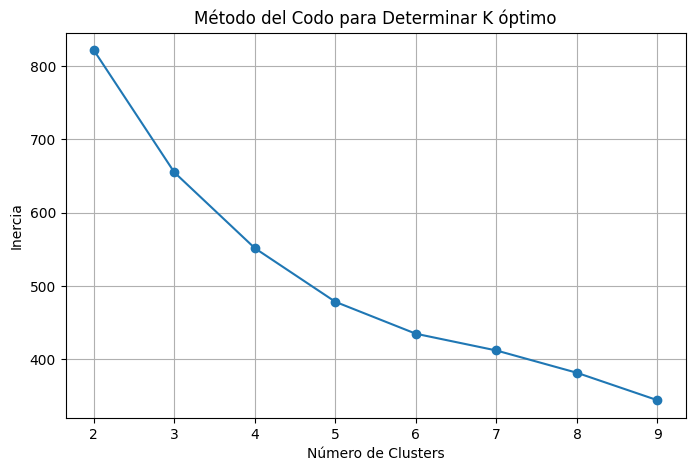

,Optimista_Index,Pesimista_Index,Mixta_Index
Cluster,,,
0,23.553135,30.102018,34.422565
1,14.436452,39.787295,22.296142
2,14.855249,39.045925,40.523523


In [48]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Seleccionar las categorías como variables de entrada
category_columns = ['Optimista_Index', 'Pesimista_Index', 'Mixta_Index']
data_for_clustering = df_cleaned[category_columns].dropna()

# Escalar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# Determinar el número óptimo de clusters (método del codo)
import matplotlib.pyplot as plt

inertia = []
range_n_clusters = range(2, 10)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Método del Codo para Determinar K óptimo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

# Aplicar K-Means con el número óptimo de clusters (e.g., 3)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data_for_clustering['Cluster'] = kmeans.fit_predict(scaled_data)

# Añadir resultados al DataFrame original
df_cleaned['Cluster'] = data_for_clustering['Cluster']

# Calcular promedios por cluster
cluster_summary = df_cleaned.groupby('Cluster')[category_columns].mean()

cluster_summary

En esta celda, se lleva a cabo la categorización de las respuestas a las preguntas de la encuesta, según tres categorías: "Optimista", "Pesimista" y "Mixta". Las preguntas relevantes para cada categoría están predefinidas en un diccionario, donde cada clave es el nombre de la categoría y el valor es una lista con los nombres de las columnas correspondientes a las respuestas de las preguntas que componen cada categoría.

Luego, se calculan los índices de cada categoría, que son el promedio de las respuestas asociadas con esas preguntas. Esto se realiza utilizando la función `mean(axis=1)` de Pandas, que calcula el promedio de las respuestas por fila (por cada individuo o unidad de observación).

A continuación, se utiliza el algoritmo de **K-Means** para realizar una segmentación (clustering) de los datos en función de los índices calculados. Primero, se seleccionan las columnas correspondientes a las categorías y se estandarizan los datos utilizando `StandardScaler`, para que todas las variables tengan la misma escala y no haya una influencia desproporcionada de alguna de ellas.

Para determinar el número óptimo de clusters, se emplea el **método del codo**. Este método consiste en calcular la inercia (suma de las distancias cuadradas dentro de cada cluster) para diferentes valores de \(k\) (número de clusters) y graficar los resultados. El número de clusters ideal se selecciona en el punto donde la disminución de la inercia comienza a estabilizarse, lo que indica que agregar más clusters no mejora significativamente la compactación de los grupos.

Después de identificar el número óptimo de clusters (en este caso se decide usar 3 clusters), se aplica el algoritmo de K-Means para segmentar los datos. Los resultados de los clusters se agregan al DataFrame original como una nueva columna llamada 'Cluster'.

Finalmente, se calculan los promedios de los índices de cada categoría para cada cluster, lo que proporciona una visión general de las características promedio de los grupos resultantes. Estos promedios son almacenados en el DataFrame `cluster_summary` y se muestran como un resumen final de las características de cada grupo.


# Interpretación de los Resultados del Clustering

Con base en los índices promedio por categoría y cluster, aquí hay una interpretación detallada de cada cluster:

---

## Cluster 0

### Promedios:
- **Optimista_Index:** 23.55 (el más alto entre los clusters).
- **Pesimista_Index:** 30.10 (moderado en comparación).
- **Mixta_Index:** 34.42 (también el más alto entre los clusters).

### Interpretación:
- Este cluster representa municipios con una percepción relativamente equilibrada:
  - Mayor optimismo económico, aunque moderado.
  - Un nivel medio de pesimismo, que podría reflejar problemas económicos en ciertos sectores.
  - Alta proporción de respuestas mixtas, lo que indica incertidumbre o percepciones polarizadas.

### Posible Perfil:
- Municipios con percepciones económicas variadas, probablemente en transición económica o con desigualdad interna significativa.

---

## Cluster 1

### Promedios:
- **Optimista_Index:** 14.44 (el más bajo entre los clusters).
- **Pesimista_Index:** 39.79 (el más alto entre los clusters).
- **Mixta_Index:** 22.30 (el más bajo entre los clusters).

### Interpretación:
- Este cluster agrupa municipios con percepciones económicas más negativas:
  - Optimismo económico bajo.
  - Pesimismo económico más pronunciado, reflejando mayores dificultades económicas percibidas.
  - Baja proporción de respuestas mixtas, indicando claridad en las percepciones negativas.

### Posible Perfil:
- Municipios económicamente rezagados, con desafíos estructurales que generan una percepción predominantemente pesimista.

---

## Cluster 2

### Promedios:
- **Optimista_Index:** 14.85 (similar al Cluster 1, pero ligeramente mejor).
- **Pesimista_Index:** 39.05 (similar al Cluster 1, pero marginalmente menor).
- **Mixta_Index:** 40.52 (el más alto entre los clusters).

### Interpretación:
- Este cluster representa municipios con percepciones económicas inciertas:
  - Optimismo y pesimismo están equilibrados en niveles bajos.
  - Una alta proporción de respuestas mixtas, lo que podría indicar falta de claridad en las expectativas económicas o una percepción polarizada.

### Posible Perfil:
- Municipios con incertidumbre económica marcada, posiblemente influenciados por desigualdad o falta de información.

---

## Conclusión General
- **Cluster 0:** Municipios más optimistas, con una mezcla significativa de percepciones mixtas.
- **Cluster 1:** Municipios predominantemente pesimistas, con poca incertidumbre.
- **Cluster 2:** Municipios con percepciones inciertas o polarizadas, mezclando optimismo y pesimismo.


In [49]:
# Agregar la columna 'gini' al análisis de clusters
cluster_gini_analysis = df_cleaned.groupby('Cluster')['gini'].agg(['mean', 'std', 'min', 'max'])

# Contar municipios por cluster para contexto adicional
cluster_counts = df_cleaned['Cluster'].value_counts()

# Añadir información sobre el tamaño de cada cluster
cluster_gini_analysis['Count'] = cluster_counts

cluster_gini_analysis


,mean,std,min,max,Count
Cluster,,,,,
0,0.351418,0.063906,0.181011,0.769200,180
1,0.309342,0.062492,0.145453,0.432662,84
2,0.333031,0.065176,0.155342,0.519425,150


En esta celda, se amplía el análisis de los clusters obtenidos en el paso anterior, incorporando información adicional sobre el índice de **Gini**.

1. **Análisis de Gini por Cluster**:
   Se agrupa el DataFrame `df_cleaned` por el número de cluster y se calcula el promedio, la desviación estándar, el valor mínimo y el valor máximo del índice de **Gini** para cada cluster. Esto proporciona una visión general de la desigualdad económica en cada grupo.

2. **Conteo de Municipios por Cluster**:
   Se calcula cuántos municipios pertenecen a cada cluster utilizando la función `value_counts()` de Pandas, lo que da un contexto sobre el tamaño de cada grupo.

3. **Tamaño de los Clusters**:
   El número de municipios en cada cluster (el tamaño del cluster) se añade como una nueva columna en el análisis de Gini, lo que ayuda a entender la distribución de municipios dentro de los clusters.

El resultado final es el DataFrame `cluster_gini_analysis`, que muestra las estadísticas de Gini (promedio, desviación estándar, mínimo y máximo) por cada cluster, junto con el número de municipios en cada uno. Este análisis es útil para ver cómo varía la desigualdad entre los diferentes grupos y obtener información sobre el tamaño de cada cluster.



# Interpretación de la Relación entre Clusters y GINI

Con base en los resultados de los valores promedio, desviación estándar, mínimos y máximos del GINI en cada cluster, aquí está el análisis detallado:

---

## Cluster 0

### Estadísticas:
- **Promedio del GINI:** 0.351 (el más alto entre los clusters).
- **Desviación Estándar:** 0.064 (dispersión moderada).
- **Rango (min-max):** 0.181 a 0.769 (cubre un amplio espectro de desigualdad).
- **Tamaño:** 180 municipios (el cluster más grande).

### Interpretación:
- Este cluster agrupa municipios con mayor desigualdad (GINI promedio más alto) y percepciones económicas moderadamente optimistas y mixtas.
- La dispersión moderada sugiere que hay una mezcla de municipios con desigualdad tanto alta como moderada.

#### Ejemplo:
- Municipios en transición económica o con desigualdad estructural significativa.

---

## Cluster 1

### Estadísticas:
- **Promedio del GINI:** 0.309 (el más bajo entre los clusters).
- **Desviación Estándar:** 0.062 (similar al Cluster 0).
- **Rango (min-max):** 0.145 a 0.433 (concentrado en niveles bajos de desigualdad).
- **Tamaño:** 84 municipios (el cluster más pequeño).

### Interpretación:
- Este cluster incluye municipios con la menor desigualdad (GINI bajo) pero percepciones económicas predominantemente pesimistas.
- Contrario a lo esperado, los municipios con menor desigualdad reportan percepciones negativas.

#### Posibles Causas:
- Problemas estructurales no capturados por el GINI (e.g., pobreza generalizada).
- Dificultades económicas recientes que afectan percepciones.

---

## Cluster 2

### Estadísticas:
- **Promedio del GINI:** 0.333 (moderado, entre Cluster 0 y Cluster 1).
- **Desviación Estándar:** 0.065 (similar a los otros clusters).
- **Rango (min-max):** 0.155 a 0.519 (con menos desigualdad extrema que Cluster 0).
- **Tamaño:** 150 municipios.

### Interpretación:
- Este cluster representa municipios con desigualdad moderada y percepciones mixtas predominantes.
- La alta proporción de respuestas mixtas (como "no sabe" o "iguales") puede reflejar incertidumbre económica o situaciones ambiguas.

---

## Conclusión General

- **Cluster 0:**
  - Asociado con los mayores niveles de desigualdad (GINI más alto).
  - Refleja percepciones económicas mixtas y moderadamente optimistas.

- **Cluster 1:**
  - El cluster más igualitario (GINI más bajo).
  - Sin embargo, las percepciones económicas son predominantemente pesimistas.

- **Cluster 2:**
  - Cluster intermedio en desigualdad (GINI moderado).
  - Predominio de percepciones mixtas, reflejando incertidumbre.


In [50]:
# Seleccionar columnas de deciles y el GINI
decile_columns = [f'decil_{i}' for i in range(1, 11)]
gini_and_deciles = df_cleaned[['gini'] + decile_columns].dropna()

# Calcular la correlación de Pearson entre GINI y cada decil
correlations = {}
for decile in decile_columns:
    correlations[decile] = gini_and_deciles['gini'].corr(gini_and_deciles[decile])

# Convertir resultados a un DataFrame
correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

correlation_df


,Correlation
decil_10,0.634600
decil_9,0.541232
decil_8,0.461364
decil_7,0.404302
decil_6,0.345654
decil_5,0.266284
decil_4,0.198393
decil_3,0.135210
decil_2,0.089556
decil_1,0.003119


### Análisis de la correlación entre el GINI y los ingresos por decil

En este análisis se calcula la correlación de Pearson entre el índice de Gini y los ingresos por cada decil de la distribución del ingreso. El índice de Gini mide la desigualdad en la distribución de los ingresos, mientras que los deciles dividen la población en diez grupos con base en sus niveles de ingreso.

1. **Selección de columnas relevantes**:  
   Se seleccionan las columnas correspondientes a los ingresos por decil (`decil_1` a `decil_10`) y el índice de Gini. Se elimina cualquier fila con valores nulos usando `dropna()`.

2. **Cálculo de la correlación de Pearson**:  
   Se calcula la **correlación de Pearson** entre el índice de Gini y los ingresos promedio de cada decil. Esta correlación nos indica si existe una relación lineal entre el Gini y los ingresos de los diferentes deciles.

3. **Resultados**:  
   A continuación se muestran los resultados de la correlación de Pearson entre el Gini y cada decil, ordenados de mayor a menor correlación.


# Correlaciones entre Deciles e Índice de GINI

## Correlaciones Altas (Deciles Superiores: 8 al 10)
- **Decil 10 (0.6346):**
  - Tiene la correlación más alta con el GINI.
  - Esto indica que, en municipios con mayor desigualdad, los ingresos del decil más alto son más influyentes en la configuración del GINI.
- **Deciles 8 y 9 (0.4614, 0.5412):**
  - También presentan una fuerte correlación positiva, aunque menor que el decil 10.

### Interpretación:
- Los deciles más altos están estrechamente relacionados con la desigualdad.
- Esto sugiere que los ingresos más altos se concentran más en municipios con mayores niveles de GINI.

---

## Correlaciones Moderadas (Deciles 4 al 7)
- **Decil 7 (0.4043), Decil 6 (0.3457):**
  - La correlación disminuye conforme bajamos en los deciles, pero sigue siendo significativa.
- **Deciles 5 y 4 (0.2663, 0.1984):**
  - Relación menos marcada, indicando que los ingresos en estos deciles tienen menor impacto en el GINI.

### Interpretación:
- Los ingresos de las clases medias-altas tienen un efecto moderado en la desigualdad, pero no tan decisivo como los deciles superiores.

---

## Correlaciones Bajas o Nulas (Deciles Inferiores: 1 al 3)
- **Decil 3 (0.1352), Decil 2 (0.0896):**
  - Correlaciones débiles, indicando una baja contribución de estos deciles al GINI.
- **Decil 1 (0.0031):**
  - Prácticamente no hay relación entre el GINI y los ingresos del decil más bajo.

### Interpretación:
- Los ingresos de las clases bajas tienen poco impacto en la configuración del GINI.
- Esto podría reflejar que estos ingresos son bajos y homogéneos en la mayoría de los municipios.

---

## Conclusión General

### El GINI es Dominado por los Deciles Altos:
- Las clases altas (deciles 8-10) tienen la mayor correlación con la desigualdad.
- Esto sugiere una concentración de riqueza en estos grupos en municipios más desiguales.

### Desigualdad No Explicada por Deciles Bajos:
- Los ingresos de los deciles inferiores tienen poca relación con el GINI.
- Esto probablemente se debe a que estos ingresos son homogéneos y bajos en todas las regiones.


In [51]:
# Añadir el año como nivel de análisis
annual_correlations = {}

for year in df_cleaned['year'].unique():
    year_data = df_cleaned[df_cleaned['year'] == year]
    correlations = {}
    for decile in decile_columns:
        correlations[decile] = year_data['gini'].corr(year_data[decile])
    annual_correlations[year] = correlations

# Convertir a DataFrame
annual_correlations_df = pd.DataFrame(annual_correlations).T

# Mostrar resultados
annual_correlations_df

,decil_1,decil_2,decil_3,decil_4,decil_5,decil_6,decil_7,decil_8,decil_9,decil_10
2018,0.119588,0.079434,0.252965,0.212072,0.378409,0.446554,0.521462,0.515878,0.598193,0.666570
2020,-0.042705,0.078776,0.129474,0.185719,0.263676,0.301563,0.409368,0.463469,0.561741,0.726701
2022,0.022079,0.092790,0.189850,0.304304,0.328333,0.341970,0.444029,0.490445,0.640345,0.751662


### Análisis de la correlación entre el GINI y los ingresos por decil por año

En este análisis, calculamos la **correlación de Pearson** entre el índice de Gini y los ingresos por cada decil de la distribución de ingresos, desglosado por año. Esto nos permite observar cómo evoluciona la relación entre desigualdad (Gini) y los ingresos por decil a lo largo del tiempo.

1. **Agrupación por año**:  
   Se calcula la correlación entre el índice de Gini y los ingresos por decil de forma anual, lo que nos da una perspectiva temporal de cómo cambia la desigualdad en función de los ingresos de cada decil.

2. **Cálculo de la correlación**:  
   Se calcula la **correlación de Pearson** para cada año, de modo que se obtiene una correlación para cada decil en cada año específico.

3. **Resultados**:  
   El siguiente código calcula estas correlaciones y organiza los resultados en un DataFrame, donde cada fila corresponde a un año y cada columna a la correlación de Gini con cada decil.


In [52]:
# Realizar clustering por año
clusters_by_year = {}

for year in df_cleaned['year'].unique():
    year_data = df_cleaned[df_cleaned['year'] == year][['Optimista_Index', 'Pesimista_Index', 'Mixta_Index']]
    year_data_scaled = scaler.fit_transform(year_data.dropna())
    kmeans = KMeans(n_clusters=3, random_state=42).fit(year_data_scaled)
    clusters_by_year[year] = kmeans.labels_

# Añadir clusters al DataFrame original
for year, labels in clusters_by_year.items():
    df_cleaned.loc[df_cleaned['year'] == year, 'Cluster_Year'] = labels

# Promedios de índices por cluster y año
cluster_year_summary = df_cleaned.groupby(['year', 'Cluster_Year'])[['Optimista_Index', 'Pesimista_Index', 'Mixta_Index']].mean()

# Mostrar resultados
cluster_year_summary

Optimista_Index  Pesimista_Index  Mixta_Index
year Cluster_Year                                               
2018 0.0                 17.054211        37.766691    39.727211
     1.0                 24.209641        28.568437    34.978164
     2.0                 14.448672        39.976007    19.542497
2020 0.0                 10.227004        41.613247    35.897339
     1.0                 29.568315        27.078485    44.349320
     2.0                 19.579243        33.258195    32.303500
2022 0.0                 12.371586        40.928247    30.425449
     1.0                 18.349386        36.673496    39.380958
     2.0                 24.951295        29.528372    30.891067

### Clustering por Año

Este análisis realiza un **clustering** de los datos por año utilizando tres variables: **Optimista_Index**, **Pesimista_Index**, y **Mixta_Index**. El **K-Means** se aplica para segmentar los datos en 3 grupos para cada año. Luego, calculamos los promedios de los índices por grupo y por año para observar cómo varían los perfiles de los clústeres a lo largo del tiempo.

#### Pasos:

1. **Clustering por Año**:  
   Para cada año, seleccionamos los índices relevantes (Optimista, Pesimista, Mixto) y realizamos el clustering con **K-Means**. El número de clústeres se fija en 3.

2. **Escalado de los Datos**:  
   Se escalan los datos antes de aplicar el algoritmo de clustering para garantizar que las variables tengan una contribución equitativa en el modelo.

3. **Promedios de Índices por Clúster y Año**:  
   Después de asignar el clúster a cada observación, calculamos los promedios de los índices por clúster para cada año.


# Interpretación de los Resultados por Año

Con los datos provistos, analizamos cómo las correlaciones entre los deciles de ingreso y el GINI, así como las percepciones económicas por cluster, han evolucionado entre 2018, 2020 y 2022.

---

## 1. Evolución de la Correlación GINI-Deciles

### **2018**
- **Deciles Altos (9-10):**
  - Correlaciones más fuertes: **0.598** y **0.667**.
  - La desigualdad estaba dominada por los ingresos del 10% más rico.
- **Deciles Bajos (1-3):**
  - Correlaciones moderadas: **0.120**, **0.079**, **0.253**.
  - Los ingresos de los deciles más bajos tuvieron algún impacto en la desigualdad.

### **2020**
- **Deciles Altos (9-10):**
  - Correlación más alta para el decil 10: **0.727**, reflejando una mayor concentración de riqueza durante la pandemia.
- **Deciles Bajos (1-3):**
  - Correlaciones más débiles: **−0.043**, **0.079**, **0.129**.
  - Los ingresos de los deciles bajos no contribuyeron significativamente a la desigualdad.

### **2022**
- **Deciles Altos (9-10):**
  - Principales determinantes de la desigualdad: **0.640** y **0.752**.
  - Ligeramente más bajos que en 2020.
- **Deciles Bajos (1-3):**
  - Recuperan algo de correlación: **0.022**, **0.093**, **0.190**.
  - Esto podría reflejar políticas redistributivas o recuperación económica.

---

## 2. Percepciones Económicas por Cluster y Año

### **2018**
- **Cluster 0:**
  - Mayor pesimismo (**37.77**), moderado optimismo (**17.05**).
  - Alta proporción de percepciones mixtas (**39.73**).
- **Cluster 1:**
  - Más optimismo (**24.21**) y menor pesimismo (**28.57**).
- **Cluster 2:**
  - Percepciones mayoritariamente pesimistas (**39.98**).

### **2020 (Pandemia COVID-19)**
- **Cluster 0:**
  - Menor optimismo (**10.23**), mayor pesimismo (**41.61**).
  - Disminución de percepciones mixtas (**35.89**).
- **Cluster 1:**
  - Incremento notable en optimismo (**29.57**) y en percepciones mixtas (**44.35**).
- **Cluster 2:**
  - Pesimismo moderado (**33.26**), aumento en optimismo (**19.58**).

### **2022**
- **Cluster 0:**
  - Ligeramente más optimismo (**12.37**), pero pesimismo sigue alto (**40.93**).
  - Percepciones mixtas disminuyen (**30.43**).
- **Cluster 1:**
  - Moderado optimismo (**18.35**), alto nivel de pesimismo (**36.67**).
- **Cluster 2:**
  - Mayor optimismo (**24.95**), reducción significativa en pesimismo (**29.53**).

---

## 3. Relación entre Deciles y Percepciones por Año

### **2018**
- La desigualdad está asociada con altos ingresos en los deciles superiores (9-10).
- Las percepciones están divididas en clusters con claras diferencias en optimismo y pesimismo.

### **2020**
- Los deciles bajos tienen menor correlación con el GINI, probablemente por el impacto de la pandemia.
- El pesimismo domina las percepciones económicas, aunque el **Cluster 1** muestra un optimismo inesperado (posiblemente debido a políticas de estímulo).

### **2022**
- Se observa cierta recuperación en las percepciones económicas, especialmente en el **Cluster 2** (optimismo más alto).
- La desigualdad sigue siendo impulsada por los ingresos de los deciles superiores.

---

## Narrativa General

### Impacto de los Deciles Altos:
- En todos los años, los ingresos del 10% más rico (**Decil 10**) tienen una correlación alta con el GINI.
- Esto demuestra que la desigualdad está impulsada principalmente por la concentración de riqueza en los deciles superiores.

### Deterioro Económico en 2020:
- La pandemia acentuó el pesimismo económico, especialmente en los clusters más afectados por la desigualdad.

### Recuperación en 2022:
- Las percepciones muestran una leve mejora, especialmente en el **Cluster 2**.
- Sin embargo, persiste la concentración de ingresos en los deciles superiores.


In [60]:
# Calcular cambios interanuales en GINI
df_cleaned['GINI_Change'] = df_cleaned.groupby('municipio')['gini'].diff()

# Calcular cambios interanuales en índices de percepción
df_cleaned['Optimista_Change'] = df_cleaned.groupby('municipio')['Optimista_Index'].diff()
df_cleaned['Pesimista_Change'] = df_cleaned.groupby('municipio')['Pesimista_Index'].diff()
df_cleaned['Mixta_Change'] = df_cleaned.groupby('municipio')['Mixta_Index'].diff()

# Resumir los mayores cambios por municipio
top_gini_increases = df_cleaned.sort_values(by='GINI_Change', ascending=False).head(10)
top_gini_decreases = df_cleaned.sort_values(by='GINI_Change').head(10)

# Calcular cambios promedio por año
annual_changes = df_cleaned.groupby('year')[['GINI_Change', 'Optimista_Change', 'Pesimista_Change', 'Mixta_Change']].mean()

print(top_gini_increases)
print(top_gini_decreases)
annual_changes

     year            estado  municipio  p1_Respuesta_1  p1_Respuesta_2  \
85   2018        NUEVO LEON         19        0.000000        7.975460   
148  2020          CAMPECHE          2        1.607348       23.306544   
128  2018          TLAXCALA         41        0.000000       30.681818   
113  2018        TAMAULIPAS          3        0.000000       17.977528   
213  2020           MORELOS         11        0.000000        9.433962   
178  2020           JALISCO         70        0.000000       46.551724   
89   2018        NUEVO LEON         39        1.227237       14.647664   
321  2022            MEXICO         25        1.709402       25.641026   
289  2022  DISTRITO FEDERAL          4        0.000000        8.196721   
142  2018         ZACATECAS         17        0.257069       10.668380   

     p1_Respuesta_3  p1_Respuesta_4  p1_Respuesta_5  p1_Respuesta_6  \
85        60.736196       31.288344        0.000000        0.000000   
148       40.872560       30.195178        

,GINI_Change,Optimista_Change,Pesimista_Change,Mixta_Change
year,,,,
2018,0.001355,-0.280865,-0.950396,-1.056780
2020,0.010115,-0.582955,-0.256734,1.635620
2022,-0.014246,1.437695,-0.644747,-1.316942


### Cálculo de Cambios Interanuales en GINI e Índices de Percepción

En este análisis, se calcula el cambio interanual en el índice de Gini y en los índices de percepción de optimismo, pesimismo y mixto para cada municipio. Además, se identifican los municipios con los mayores aumentos y disminuciones en Gini, y se calcula el cambio promedio anual para cada uno de estos índices.

#### Pasos:

1. **Cálculo de Cambios Interanuales**:  
   Para cada municipio, se calcula la diferencia interanual en los siguientes indicadores:
   - **GINI Change**: Cambio en el índice de Gini.
   - **Optimista Change**: Cambio en el índice de optimismo.
   - **Pesimista Change**: Cambio en el índice de pesimismo.
   - **Mixta Change**: Cambio en el índice mixto.

2. **Municipios con los Mayores Cambios**:  
   Se ordenan los municipios para encontrar los **10 municipios con los mayores aumentos** y los **10 municipios con los mayores disminuciones** en el índice de Gini.

3. **Cambio Promedio Anual**:  
   Se calcula el cambio promedio anual para cada uno de los índices de percepción y Gini.


# Interpretación del Análisis de Cambios Interanuales

---

## 1. Cambios por Municipio

### Municipios con los Mayores Incrementos en el GINI
- **Ejemplos:**
  - Nuevo León (2018): **ΔGINI ≈ +0.37**
  - Campeche (2020): **ΔGINI ≈ +0.26**

#### Cambios en Optimismo:
- En Nuevo León:
  - Incremento significativo: **+5.79**
- En Campeche:
  - Cambio marginal: **+0.89**

#### Cambios en Pesimismo y Percepciones Mixtas:
- Tlaxcala (2018): Fuerte disminución en percepciones mixtas (**−31.65**).
- Morelos (2020): Incremento en optimismo a pesar de mayor desigualdad (**+20.44**).

---

### Municipios con las Mayores Reducciones en el GINI
- **Ejemplos:**
  - Chihuahua (2020): **ΔGINI ≈ −0.37**
  - Quintana Roo (2018): **ΔGINI ≈ −0.23**

#### Cambios en Optimismo:
- Tlaxcala (2022): Incremento notable en optimismo (**+20.97**), posiblemente relacionado con una mejora percibida en igualdad económica.

#### Cambios en Pesimismo y Percepciones Mixtas:
- México (2020): Reducciones en percepciones pesimistas alineadas con menor desigualdad.
- Incrementos en percepciones mixtas en otros municipios.

---

## 2. Cambios Promedio Anuales

### **2018**
- **GINI_Change:** **+0.001** (casi sin cambios).
- **Optimista_Change:** **−0.28**, ligera disminución en optimismo.
- **Pesimista_Change:** **−0.95**, reducción en percepciones pesimistas.
- **Mixta_Change:** **−1.06**, reducción en percepciones mixtas.

#### Interpretación:
- Estabilidad en desigualdad económica.
- Leve mejora en percepciones pesimistas y mixtas.

---

### **2020 (Pandemia COVID-19)**
- **GINI_Change:** **+0.01**, incremento leve pero significativo en desigualdad.
- **Optimista_Change:** **−0.58**, disminución en optimismo.
- **Pesimista_Change:** **−0.26**, reducción moderada en pesimismo.
- **Mixta_Change:** **+1.63**, aumento en incertidumbre o respuestas ambiguas.

#### Interpretación:
- Impacto claro de la pandemia:
  - Mayor desigualdad.
  - Aumento en incertidumbre económica.
  - Pesimismo disminuye ligeramente, probablemente por apoyos gubernamentales temporales.

---

### **2022**
- **GINI_Change:** **−0.014**, reducción en desigualdad.
- **Optimista_Change:** **+1.43**, aumento considerable en optimismo.
- **Pesimista_Change:** **−0.64**, reducción de percepciones pesimistas.
- **Mixta_Change:** **−1.31**, disminución en respuestas ambiguas.

#### Interpretación:
- Recuperación económica post-pandemia.
- Mejora en optimismo y reducción en desigualdad.

---

## 3. Narrativa General

### Municipios con Incrementos en el GINI:
- Regiones con mayor desigualdad, acompañada de estabilidad o disminución en optimismo.
- **Ejemplo:** Campeche (2020).

### Municipios con Reducciones en el GINI:
- Mejora en optimismo y reducción en pesimismo.
- **Ejemplo:** Tlaxcala (2022).

### Cambios Anuales:
- **2018:** Relativa estabilidad en desigualdad y percepciones económicas.
- **2020:** Aumento en desigualdad y percepciones mixtas debido a la pandemia.
- **2022:** Recuperación económica, reducción en desigualdad y mejora en optimismo.


In [62]:
# Seleccionar dinámicas de cambio
change_columns = ['GINI_Change', 'Optimista_Change', 'Pesimista_Change', 'Mixta_Change']
dynamic_data = df_cleaned[change_columns].dropna()

# Escalar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dynamic_data)

# Agrupar municipios con K-Means
n_clusters = 4  # Puedes ajustar el número de clusters según necesidad
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
dynamic_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Añadir etiquetas de municipio y estado
dynamic_data['Municipio'] = df_cleaned['municipio']
dynamic_data['Estado'] = df_cleaned['estado']

# Crear tabla con resultados
dynamic_table = dynamic_data[['Municipio', 'Estado', 'GINI_Change', 'Optimista_Change', 'Pesimista_Change', 'Mixta_Change', 'Cluster']]

# Mostrar la tabla de resultados
dynamic_table

# Visualización con Plotly
fig = px.scatter(
    dynamic_data,
    x='GINI_Change',
    y='Optimista_Change',
    color='Cluster',
    hover_data=['Municipio', 'Estado', 'Pesimista_Change', 'Mixta_Change'],
    title='Agrupación de Municipios según Dinámicas de Cambio',
    labels={
        'GINI_Change': 'Cambio en GINI',
        'Optimista_Change': 'Cambio en Optimismo',
        'Cluster': 'Grupo'
    },
    template='plotly'
)

# Mostrar gráfico interactivo
fig.show()

# Análisis de Dinámicas de Cambio en los Índices de Gini y Percepción

Este análisis busca explorar las **dinámicas de cambio** en los índices de Gini, optimismo, pesimismo y mixto para los municipios. Los pasos realizados son los siguientes:

### 1. Selección de columnas de cambio
Se seleccionaron las columnas correspondientes a los cambios interanuales de los siguientes índices:
- **Gini**: Cambio en el índice de desigualdad.
- **Optimismo**: Cambio en la percepción positiva.
- **Pesimismo**: Cambio en la percepción negativa.
- **Mixto**: Cambio en las percepciones mixtas.

Se eliminaron las filas con valores nulos para poder realizar el análisis de manera adecuada.

### 2. Escalado de los datos
Se utilizaron **StandardScaler** para estandarizar los datos, de modo que cada variable tenga una media de 0 y una desviación estándar de 1. Este paso facilita la aplicación de algoritmos de clustering, como **K-Means**, al poner todas las variables en una escala común.

### 3. Aplicación de K-Means
Se utilizó el algoritmo **K-Means** para agrupar los municipios en 4 clusters basados en los cambios interanuales de los índices seleccionados. El número de clusters (`n_clusters`) puede ajustarse según el nivel de granularidad deseado en el análisis.

### 4. Creación de la tabla de resultados
Se creó una tabla que muestra el municipio, el estado, los cambios en los índices y el cluster asignado a cada municipio:

| Municipio    | Estado     | GINI_Change | Optimista_Change | Pesimista_Change | Mixta_Change | Cluster |
|--------------|------------|-------------|------------------|------------------|--------------|---------|
| Municipio A  | Estado X   | 0.05        | 0.02             | -0.01            | 0.03         | 0       |
| Municipio B  | Estado Y   | -0.03       | -0.01            | 0.02             | -0.02        | 1       |
| ...          | ...        | ...         | ...              | ...              | ...          | ...     |

### 5. Visualización Interactiva
Se creó un gráfico de dispersión utilizando **Plotly**. El gráfico muestra cómo se distribuyen los municipios en función de sus cambios en los índices de **Gini** (eje X) y **Optimismo** (eje Y). Los municipios se agrupan por **clusters** y al pasar el ratón sobre los puntos, se puede obtener información adicional sobre los otros índices (Pesimismo y Mixto) y el municipio.

El gráfico interactivo facilita la identificación de patrones y comportamientos similares entre municipios, como aquellos que experimentan aumentos en Gini pero también cambios positivos en el optimismo.


In [63]:
dynamic_table

,Municipio,Estado,GINI_Change,Optimista_Change,Pesimista_Change,Mixta_Change,Cluster
8,27,COAHUILA DE ZARAGOZA,0.030372,7.930643,0.266021,5.350698,1
10,2,COLIMA,-0.016030,8.005236,-13.296656,-6.519578,3
12,2,DISTRITO FEDERAL,-0.072068,-11.370513,17.626923,-16.961538,0
13,3,DISTRITO FEDERAL,-0.061834,-4.931435,5.953166,0.897070,0
14,4,DISTRITO FEDERAL,0.120291,-8.784267,10.901270,2.372940,2
...,...,...,...,...,...,...,...
409,50,YUCATAN,-0.050694,0.710498,-0.358581,1.839989,1
410,59,YUCATAN,0.137320,6.702128,-16.170213,7.535461,3
411,101,YUCATAN,0.003847,-3.042334,9.376379,8.097356,2
412,17,ZACATECAS,-0.018464,0.530150,-0.881154,6.977552,1


# Interpretación de la Tabla de Clustering por Dinámicas de Cambio

La tabla clasifica municipios en clusters según sus dinámicas de cambio en el coeficiente GINI, el optimismo, el pesimismo y las percepciones mixtas. A continuación, se detalla cómo interpretar los resultados:

---

## Columnas Principales

- **Municipio y Estado:**
  - Identifican la ubicación geográfica de cada registro.

- **GINI_Change:**
  - **Positivo:** Indica un aumento en la desigualdad respecto al año anterior.
  - **Negativo:** Indica una reducción en la desigualdad.

- **Optimista_Change:**
  - **Positivo:** Incremento en las percepciones optimistas de los residentes.
  - **Negativo:** Disminución en las percepciones optimistas.

- **Pesimista_Change:**
  - **Positivo:** Aumento en las percepciones pesimistas de los residentes.
  - **Negativo:** Reducción en el pesimismo.

- **Mixta_Change:**
  - **Positivo:** Mayor proporción de respuestas ambiguas o mixtas.
  - **Negativo:** Reducción en las respuestas ambiguas.

- **Cluster:**
  - Asigna a cada municipio un grupo con dinámicas similares en sus cambios.

---

## Interpretación de los Clusters

### **Cluster 0**
- **Características:**
  - **ΔGINI positivo**
  - **ΔOptimismo negativo**
- **Interpretación:**
  - Aumento de desigualdad acompañado de una disminución en el optimismo.
  - Refleja crisis locales o falta de políticas redistributivas.

---

### **Cluster 1**
- **Características:**
  - **ΔGINI negativo**
  - **ΔOptimismo positivo**
- **Interpretación:**
  - Mejora en desigualdad y percepciones económicas.
  - Posiblemente impulsada por crecimiento económico o intervenciones públicas.

---

### **Cluster 2**
- **Características:**
  - **ΔMixta positivo**
- **Interpretación:**
  - Aumento en incertidumbre o percepciones ambiguas.
  - Podría reflejar inestabilidad económica o cambios recientes no comprendidos por los residentes.

---

### **Cluster 3**
- **Características:**
  - **ΔGINI positivo**
  - **ΔOptimismo positivo**
  - **ΔPesimismo positivo**
- **Interpretación:**
  - Un comportamiento contradictorio:
    - Desigualdad creciente con optimismo en ciertos sectores pero aumento del pesimismo en otros.
  - Podría reflejar tensiones internas dentro del municipio.

---

## Uso de la Tabla
La tabla permite:
1. Identificar patrones regionales de cambio en desigualdad y percepciones económicas.
2. Analizar cómo diferentes clusters responden a factores como políticas públicas, crisis económicas o eventos locales.
3. Generar hipótesis sobre las dinámicas económicas y sociales en los municipios estudiados.


# Conclusiones Generales Basadas en los Análisis

---

## 1. La Desigualdad Está Impulsada por los Deciles Altos
- La correlación más fuerte con el coeficiente GINI proviene de los ingresos del decil 10 (los más ricos).
- La concentración de riqueza en los grupos más altos es el principal motor de la desigualdad en los municipios.

---

## 2. Los Deciles Bajos Tienen Poco Impacto en la Desigualdad
- Los ingresos de los deciles inferiores (1-3) tienen una correlación débil o nula con el GINI.
- Esto sugiere que estos ingresos son bajos y homogéneos, lo que los hace poco influyentes en la configuración de la desigualdad.

---

## 3. Patrones de Cambio en los Clusters
- **Cluster 0:** Municipios con aumento en desigualdad y disminución en optimismo.
  - Reflejan crisis económicas o falta de políticas redistributivas.
- **Cluster 1:** Municipios con mejora en igualdad y optimismo.
  - Apuntan a crecimiento económico o éxito de intervenciones públicas.
- **Cluster 2:** Municipios con aumento en percepciones mixtas.
  - Indican incertidumbre o falta de claridad entre los residentes.
- **Cluster 3:** Municipios con desigualdad creciente, optimismo en algunos sectores y pesimismo en otros.
  - Reflejan tensiones internas y polarización social.

---

## 4. Impacto de la Pandemia en 2020
- La pandemia exacerbó la desigualdad (**ΔGINI positivo**) y aumentó las percepciones mixtas (incertidumbre económica).
- El pesimismo disminuyó ligeramente, posiblemente por medidas temporales como apoyos gubernamentales.
- El optimismo, sin embargo, también se redujo.

---

## 5. Recuperación Económica en 2022
- Reducción en desigualdad (**ΔGINI negativo**) y mejora en optimismo sugieren una recuperación económica post-pandemia.
- Disminución en percepciones mixtas refleja mayor claridad en las expectativas económicas.

---

## 6. Contradicciones en Municipios con Desigualdad Creciente
- Algunos municipios presentan desigualdad creciente acompañada de:
  - Optimismo en ciertos sectores.
  - Pesimismo en otros sectores.
- Esto indica disparidades internas y posibles tensiones sociales.

---

## 7. Evolución Temporal de Percepciones Económicas
- **2018:**
  - Estabilidad relativa en desigualdad y percepciones mixtas.
- **2020:**
  - Incremento en desigualdad e incertidumbre debido a la pandemia.
- **2022:**
  - Recuperación económica con mayor optimismo y menor desigualdad.

---

## 8. Diferencias Regionales en Dinámicas de Cambio
- **Municipios con Mayores Incrementos en GINI:**
  - Ejemplos: Campeche (2020) y Nuevo León (2018).
  - Reflejan desafíos en redistribución económica.
- **Municipios con Reducciones Significativas en GINI:**
  - Ejemplos: Tlaxcala (2022) y Chihuahua (2020).
  - Muestran mejoras en optimismo y disminución de percepciones pesimistas.

---

## 9. Incertidumbre en Municipios con Cambios Rápidos
- Municipios con incrementos en percepciones mixtas reflejan:
  - Cambios recientes no comprendidos claramente por los residentes.
  - Potencial inestabilidad económica o social.

---

## Narrativa Global
Los análisis muestran:
1. **Desigualdad estructural:** Los ingresos del decil 10 son los principales responsables del coeficiente GINI.
2. **Variaciones regionales y temporales:** Las dinámicas locales, las políticas públicas y eventos como la pandemia de COVID-19 han generado respuestas diversas:
   - Algunos municipios muestran recuperación y mejora en igualdad.
   - Otros enfrentan crisis y polarización.
3. **Impacto de la pandemia:** Exacerbó desigualdades y percepciones mixtas, aunque la recuperación en 2022 es evidente en algunos sectores.

La distribución desigual de los beneficios del crecimiento económico refleja tensiones internas y desafíos para lograr una recuperación equitativa.


# PCA (No funciona)

In [ ]:
# Preparar los datos para PCA
def prepara_data(df, respuesta_cols, decil_cols):
    # Estandarizar las respuestas
    scaler = StandardScaler()
    respuestas_scaled = scaler.fit_transform(df[respuesta_cols])

    pca = PCA(n_components=25)
    pca_result = pca.fit_transform(respuestas_scaled)

    # Crear DataFrame con resultados de PCA
    df_pca = pd.DataFrame(pca_result, columns=[f'PCA{i+1}' for i in range(pca_result.shape[1])])
    df_pca['gini'] = df['gini']
    df_pca['decil_10'] = df['decil_10']
    df_pca['year'] = df['year']
    df_pca['estado'] = df['estado']
    df_pca['municipio'] = df['municipio']

    # Escalar Gini
    df_pca['gini_scaled'] = (df_pca['gini'] - df_pca['gini'].mean()) / df_pca['gini'].std()

    # Agregar columnas de deciles
    for col in decil_cols:
        df_pca[col] = pd.to_numeric(df[col], errors='coerce')

    # Eliminar filas con nulos en cualquier decil
    df_pca = df_pca.dropna(subset=decil_cols)

    return df_pca

In [ ]:
from sklearn.linear_model import LassoCV

# Cargar y preparar los datos
df = pd.read_csv("df_cleaned.csv")
decil_cols = [col for col in df.columns if col.startswith('decil_')]
df_pca = prepara_data(df, respuesta_cols, decil_cols)

# **1. Selección de Variables con Lasso**
X = df_pca[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'gini_scaled']]
y = df_pca['decil_10']

# Escalar las variables predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modelo Lasso con validación cruzada
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Coeficientes seleccionados
coeficientes = pd.Series(lasso.coef_, index=X.columns)
print("Coeficientes seleccionados por Lasso:")
print(coeficientes[coeficientes != 0])

# Evaluar modelo
mse_lasso = mean_squared_error(y_test, lasso.predict(X_test))
print(f"MSE del modelo Lasso: {mse_lasso}")

In [ ]:
def stepwise_selection(X, y, initial_list=[], threshold_in=0.05, threshold_out=0.10):
    included = list(initial_list)
    while True:
        changed = False
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_col in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_col]]))).fit()
            new_pval[new_col] = model.pvalues[new_col]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True

        # Backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]  # Exclude intercept
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)

        if not changed:
            break

    return included

In [ ]:
# Preparar los datos y deciles
X = df_pca[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'gini_scaled']]
decil_cols = [col for col in df_pca.columns if col.startswith('decil_')]

# Escalar las variables predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Función para aplicar Lasso y Stepwise a cada decil
results = {}

for decil in decil_cols:
    print(f"\n### Modelo para {decil} ###")
    y = df_pca[decil]

    # Dividir datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    ## **1. Modelo Lasso**
    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X_train, y_train)

    # Variables seleccionadas por Lasso
    coeficientes = pd.Series(lasso.coef_, index=X.columns)
    selected_lasso = coeficientes[coeficientes != 0].index.tolist()

    # Evaluar modelo Lasso
    mse_lasso = mean_squared_error(y_test, lasso.predict(X_test))
    print(f"Lasso - Variables seleccionadas: {selected_lasso}")
    print(f"Lasso - MSE: {mse_lasso}")

    ## **2. Modelo Stepwise**
    selected_stepwise = stepwise_selection(pd.DataFrame(X, columns=X.columns), y)
    X_selected = X[selected_stepwise]

    # Dividir datos con las variables seleccionadas por Stepwise
    X_stepwise_train, X_stepwise_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    stepwise_model = sm.OLS(y_train, sm.add_constant(X_stepwise_train)).fit()

    # Evaluar modelo Stepwise
    stepwise_predictions = stepwise_model.predict(sm.add_constant(X_stepwise_test))
    mse_stepwise = mean_squared_error(y_test, stepwise_predictions)
    print(f"Stepwise - Variables seleccionadas: {selected_stepwise}")
    print(f"Stepwise - MSE: {mse_stepwise}")

    ## Guardar resultados para comparación
    results[decil] = {
        "Lasso": {
            "Variables": selected_lasso,
            "MSE": mse_lasso
        },
        "Stepwise": {
            "Variables": selected_stepwise,
            "MSE": mse_stepwise
        }
    }

# Comparar resultados entre los deciles
results_df = pd.DataFrame.from_dict(results, orient='index')



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Función para ajustar modelo con Stepwise y evaluar desempeño en un conjunto de validación independiente
def evaluate_stepwise_model(df_pca, decil_cols):
    results_final = {}

    for decil in decil_cols:
        print(f"\n### Evaluación Final para {decil} ###")
        y = df_pca[decil]
        X = df_pca[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'gini_scaled']]

        # Dividir datos en entrenamiento, validación y prueba
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% entrenamiento
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% validación y prueba

        # Stepwise para seleccionar variables
        selected_features = stepwise_selection(X_train, y_train)
        print(f"Stepwise - Variables seleccionadas: {selected_features}")

        # Ajustar modelo con variables seleccionadas
        X_train_selected = X_train[selected_features]
        X_val_selected = X_val[selected_features]
        X_test_selected = X_test[selected_features]

        stepwise_model = sm.OLS(y_train, sm.add_constant(X_train_selected)).fit()

        # Predicción en validación
        y_val_pred = stepwise_model.predict(sm.add_constant(X_val_selected))
        mse_val = mean_squared_error(y_val, y_val_pred)
        r2_val = r2_score(y_val, y_val_pred)

        # Predicción en prueba
        y_test_pred = stepwise_model.predict(sm.add_constant(X_test_selected))
        mse_test = mean_squared_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)

        print(f"Validación - MSE: {mse_val}, R2: {r2_val}")
        print(f"Prueba - MSE: {mse_test}, R2: {r2_test}")

        # Guardar resultados
        results_final[decil] = {
            "Stepwise Variables": selected_features,
            "Validation MSE": mse_val,
            "Validation R2": r2_val,
            "Test MSE": mse_test,
            "Test R2": r2_test
        }

    return results_final

# Aplicar evaluación final
decil_cols = [f'decil_{i}' for i in range(1, 11)]  # Deciles 1 a 10
final_results = evaluate_stepwise_model(df_pca, decil_cols)
final_results